In [ ]:
#OG neural Network: 
class NeuralNetwork:
    
    def __init__(self, input_size, hidden_sizes, output_size, activation="sigmoid", learning_rate=0.01):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.activation_name = activation
        
        # Define activation functions
        self.activation = self.get_activation_function(activation)
        self.activation_deriv = self.get_activation_derivative(activation)

        # Define layers
        self.layers = [input_size] + hidden_sizes + [output_size]
        
        # Weight initilization (Xavier Initialization)
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1 / self.layers[i]) 
                        for i in range(len(self.layers) - 1)]

    def get_activation_function(self, name):
        """Returns the corresponding activation function"""
        if name == "sigmoid":
            return lambda x: 1 / (1 + np.exp(-x))
        elif name == "relu":
            return lambda x: np.maximum(0, x)
        elif name == "tanh":
            return lambda x: np.tanh(x)
        else:
            print("not valid activation function")

    def get_activation_derivative(self, name):
        if name == "sigmoid":
            return lambda x: x * (1 - x) 
        elif name == "relu":
            return lambda x: (x > 0).astype(float)
        elif name == "tanh":
            return lambda x: 1 - x**2
        else:
            print("not valid activation function")
    
    def feedforward(self, X):
        """Does forward propagation."""
        self.a_values = [X]
        self.z_values = []
        
        for i in range(len(self.weights)):
            z = np.dot(self.a_values[-1], self.weights[i])  
            self.z_values.append(z)
            
            if i < len(self.weights) - 1:
                activation = self.activation(z)  
            else:
                if self.activation_name == "sigmoid": 
                    activation = 1 / (1 + np.exp(-np.clip(z, -500, 500)))  
                else:  
                    activation = z  
                
            self.a_values.append(activation)
        
        return self.a_values[-1]  # Output layer activation


    def backward(self, X, y):
        """Performs backpropagation and updates weights."""
        output = self.a_values[-1]
        deltas = [y - output]  # Output layer error
        
        # Compute deltas for hidden layers 
        for i in range(len(self.weights) - 1, 0, -1):
            delta = deltas[-1].dot(self.weights[i].T) * self.activation_deriv(self.a_values[i]) 
            deltas.append(delta)
    
        deltas.reverse()
    
        # Corrected weight update 
        for i in range(len(self.weights)):
            self.weights[i] += self.learning_rate * self.a_values[i].T.dot(deltas[i])


    def train(self, X, y, epochs=1000, batch_size=1):
        """Trains the network using mini-batch SGD and records the loss."""
        self.loss_history = []
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle the dataset at the beginning of each epoch
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            n_batches = 0
            
            # Process mini-batches
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
               
                output = self.feedforward(X_batch)
                loss = np.mean((y_batch - output) ** 2)
                epoch_loss += loss
                n_batches += 1
            
                self.backward(X_batch, y_batch)
            
            # Record average loss for this epoch
            avg_epoch_loss = epoch_loss / n_batches
            self.loss_history.append(avg_epoch_loss)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {avg_epoch_loss}")
        
        # Plot training loss over epochs
        plt.plot(range(epochs), self.loss_history)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Time")
        plt.show()


    def predict(self, X):
        return self.feedforward(X)

In [617]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import matplotlib.ticker as ticker
import os
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split

In [620]:
df = pd.read_excel("Ouse93-96 - Student.xlsx", sheet_name="1993-96")

In [621]:
df.shape
##we have 12 coloumn, and 1462 rows

(1462, 12)

In [624]:
df.head()

,Unnamed: 0,Mean Daily Flow - Cumecs,Unnamed: 2,Unnamed: 3,Unnamed: 4,Daily Rainfall Total - mm,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaT,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme,NaN,NaN,You are to predict the mean daily flow at Skel...
1,1993-01-01,10.4,4.393,9.291,26.1,0,0,0,4,NaN,NaN,(Cumecs = m^3/s)
2,1993-01-02,9.95,4.239,8.622,24.86,0,0,0.8,0,NaN,NaN,NaN
3,1993-01-03,9.46,4.124,8.057,23.6,0,0,0.8,0,NaN,NaN,NaN
4,1993-01-04,9.41,4.363,7.925,23.47,2.4,24.8,0.8,61.6,NaN,NaN,NaN


In [626]:
data_series = df.iloc[:, 0]
df2 = df.drop(columns=["Unnamed: 0","Unnamed: 9", "Unnamed: 10", "Unnamed: 11"], axis = 1)
df2.head()
df2.shape

(1462, 8)

In [628]:
rename_columns = ["Mean Daily Flow - Cumecs", "Mean Daily Flow - Cumecs", "Mean Daily Flow - Cumecs", "Mean Daily Flow - Cumecs", "Daily Rainfall Total - mm", "Daily Rainfall Total - mm", "Daily Rainfall Total - mm", "Daily Rainfall Total - mm"]
df2.columns = rename_columns
df2.head()

,Mean Daily Flow - Cumecs,Mean Daily Flow - Cumecs,Mean Daily Flow - Cumecs,Mean Daily Flow - Cumecs,Daily Rainfall Total - mm,Daily Rainfall Total - mm,Daily Rainfall Total - mm,Daily Rainfall Total - mm
0,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme
1,10.4,4.393,9.291,26.1,0,0,0,4
2,9.95,4.239,8.622,24.86,0,0,0.8,0
3,9.46,4.124,8.057,23.6,0,0,0.8,0
4,9.41,4.363,7.925,23.47,2.4,24.8,0.8,61.6


In [630]:
row2 = df2.iloc[0]
column_tuples = list(zip(rename_columns, row2))


In [632]:
multi_index =pd.MultiIndex.from_tuples(column_tuples, names=["Measure", "Station"])
df2.columns = multi_index
df2.head()


Measure Mean Daily Flow - Cumecs                                  \
Station                Crakehill  Skip Bridge  Westwick  Skelton   
0                      Crakehill  Skip Bridge  Westwick  Skelton   
1                           10.4        4.393     9.291     26.1   
2                           9.95        4.239     8.622    24.86   
3                           9.46        4.124     8.057     23.6   
4                           9.41        4.363     7.925    23.47   

Measure Daily Rainfall Total - mm                                         
Station            Arkengarthdale  East Cowton  Malham Tarn  Snaizeholme  
0                  Arkengarthdale  East Cowton  Malham Tarn  Snaizeholme  
1                               0            0            0            4  
2                               0            0          0.8            0  
3                               0            0          0.8            0  
4                             2.4         24.8          0.8         61.6

In [634]:
df2.insert(0, "Date", data_series)
df2.drop(index = 0, axis = 0, inplace = True)
df2.shape


(1461, 9)

In [636]:
df2.dtypes
date_range = pd.date_range(start=df2["Date"].min(), end=df2["Date"].max(), freq="D")
missing_dates = date_range.difference(df2["Date"])
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [638]:
df = df2.copy()
df = df2.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
df.insert(0, "Date", data_series)
df.head()
#df.iloc[:, 1:].plot(kind="box", figsize=(50, 6))
print("Following are the minimum values:\n")
print(df['Mean Daily Flow - Cumecs'].min())
print(df['Daily Rainfall Total - mm'].min(), "\n")
print("Following are the Maximum values:\n")
print(df['Mean Daily Flow - Cumecs'].max())
print(df['Daily Rainfall Total - mm'].max(), "\n")



Following are the minimum values:

Station
Crakehill     -999.000
Skip Bridge   -999.000
Westwick         1.954
Skelton          3.694
dtype: float64
Station
Arkengarthdale   -999.0
East Cowton         0.0
Malham Tarn         0.0
Snaizeholme         0.0
dtype: float64 

Following are the Maximum values:

Station
Crakehill      220.000
Skip Bridge     80.244
Westwick       374.061
Skelton        448.100
dtype: float64
Station
Arkengarthdale     5000.0
East Cowton        9000.0
Malham Tarn       80000.0
Snaizeholme         268.8
dtype: float64 



In [640]:
print(df.isnull().sum())
df_cleaned = df.dropna()
df_cleaned.shape

Measure                    Station       
Date                                         0
Mean Daily Flow - Cumecs   Crakehill         0
                           Skip Bridge       1
                           Westwick          0
                           Skelton           1
Daily Rainfall Total - mm  Arkengarthdale    0
                           East Cowton       1
                           Malham Tarn       0
                           Snaizeholme       0
dtype: int64


(1458, 9)

In [642]:
df_cleaned.dtypes





Measure                    Station       
Date                                         datetime64[ns]
Mean Daily Flow - Cumecs   Crakehill                float64
                           Skip Bridge              float64
                           Westwick                 float64
                           Skelton                  float64
Daily Rainfall Total - mm  Arkengarthdale           float64
                           East Cowton              float64
                           Malham Tarn              float64
                           Snaizeholme              float64
dtype: object

In [644]:
## Winsorizing the Data to preserve data ##

<Axes: >

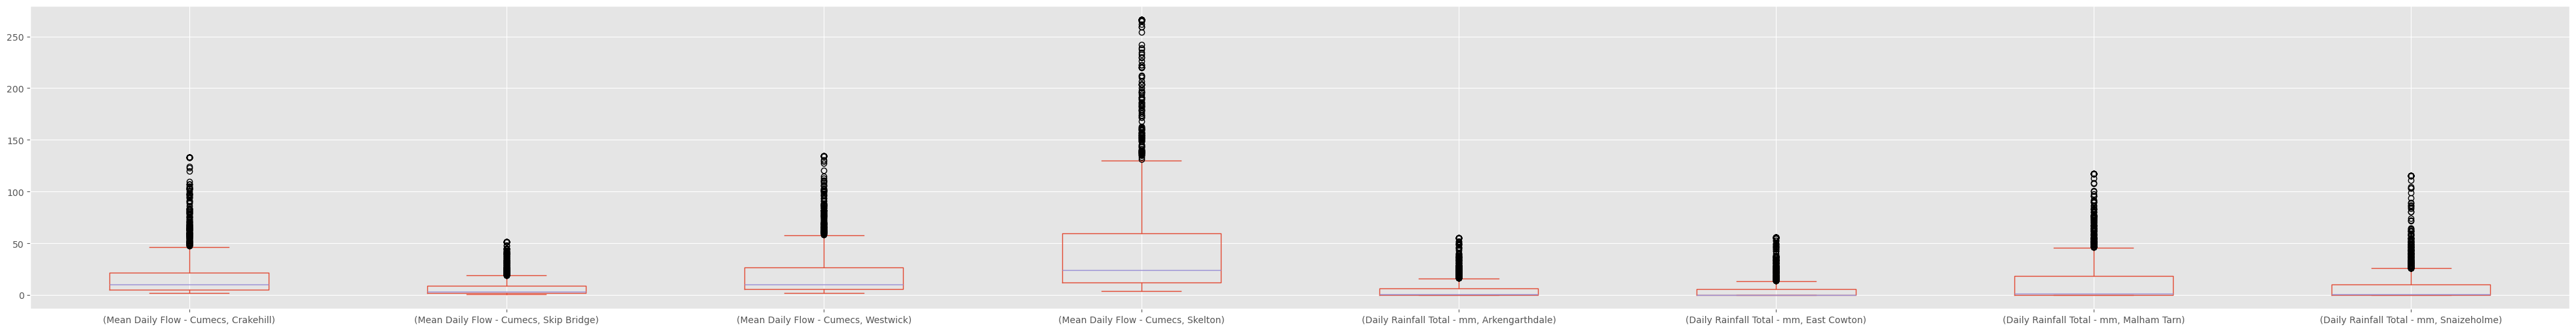

In [646]:
df_winsorized = df.apply(lambda df: winsorize(df, limits=[0.01, 0.01]))
df_winsorized.iloc[:, 1:].plot(kind="box", figsize=(50, 6))



In [647]:
df_time = df_winsorized.copy()
df_time.dtypes


Measure                    Station       
Date                                         datetime64[ns]
Mean Daily Flow - Cumecs   Crakehill                float64
                           Skip Bridge              float64
                           Westwick                 float64
                           Skelton                  float64
Daily Rainfall Total - mm  Arkengarthdale           float64
                           East Cowton              float64
                           Malham Tarn              float64
                           Snaizeholme              float64
dtype: object

In [650]:
df_time.set_index("Date", inplace=True)
df_time.index

DatetimeIndex(['1993-01-15', '1993-01-15', '1993-01-15', '1993-01-15',
               '1993-01-15', '1993-01-15', '1993-01-15', '1993-01-15',
               '1993-01-15', '1993-01-15',
               ...
               '1996-12-17', '1996-12-17', '1996-12-17', '1996-12-17',
               '1996-12-17', '1996-12-17', '1996-12-17', '1996-12-17',
               '1996-12-17', '1996-12-17'],
              dtype='datetime64[ns]', name='Date', length=1461, freq=None)

<function matplotlib.pyplot.show(close=None, block=None)>

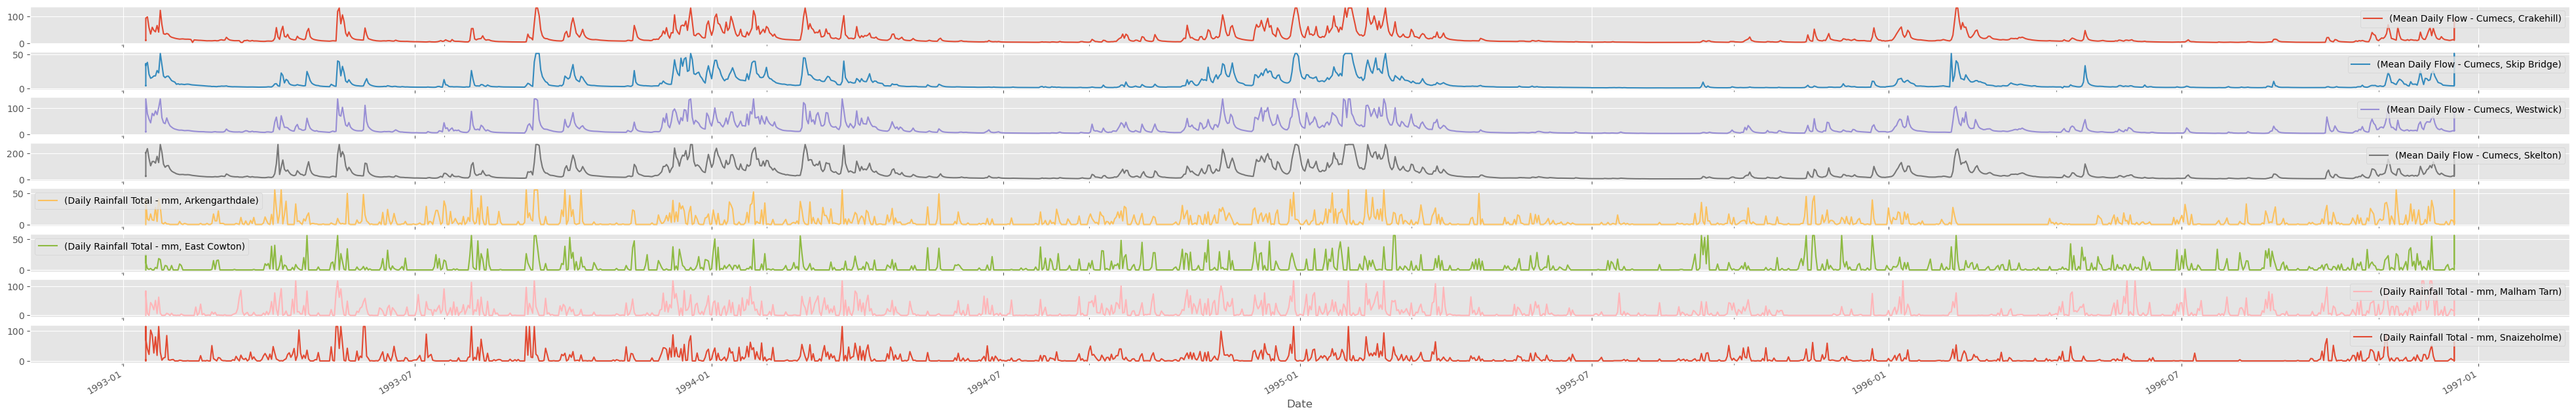

In [652]:
df_time.index
df_time.plot(figsize=(50,8), subplots=True, sharex=True)
plt.show


In [653]:
summary_stats = df_time.describe() 
summary_stats

Measure Mean Daily Flow - Cumecs                                         \
Station                Crakehill  Skip Bridge     Westwick      Skelton   
count                1461.000000  1461.000000  1461.000000  1461.000000   
mean                   19.293854     7.535781    21.120564    46.795561   
std                    23.691184     9.482550    25.092295    53.809160   
min                     2.340000     1.058000     2.185000     4.259000   
25%                     5.220000     2.168000     5.673000    12.450000   
50%                    10.100000     3.495000    10.391000    24.270000   
75%                    21.900000     8.911000    26.736000    59.440000   
max                   133.000000    51.522000   134.357000   266.000000   

Measure Daily Rainfall Total - mm                                         
Station            Arkengarthdale  East Cowton  Malham Tarn  Snaizeholme  
count                 1461.000000  1461.000000  1461.000000  1461.000000  
mean                     5.422587     5.114305    13.805065     9.419302  
std                     10.116465    10.498793    22.936933    18.716614  
min                      0.000000     0.000000     0.000000     0.000000  
25%                      0.000000     0.000000     0.000000     0.000000  
50%                      0.800000     0.000000     1.600000     0.800000  
75%                      6.400000     5.600000    18.400000    10.400000  
max                     55.200000    56.000000   117.600000   115.200000

In [654]:
corr_time = df_time.corr()
corr_time


Measure                                  Mean Daily Flow - Cumecs              \
Station                                                 Crakehill Skip Bridge   
Measure                   Station                                               
Mean Daily Flow - Cumecs  Crakehill                      1.000000    0.922585   
                          Skip Bridge                    0.922585    1.000000   
                          Westwick                       0.919979    0.872555   
                          Skelton                        0.968680    0.935077   
Daily Rainfall Total - mm Arkengarthdale                 0.354226    0.367027   
                          East Cowton                    0.234758    0.256911   
                          Malham Tarn                    0.323258    0.331211   
                          Snaizeholme                    0.379545    0.364642   

Measure                                                       \
Station                                   Westwick   Skelton   
Measure                   Station                              
Mean Daily Flow - Cumecs  Crakehill       0.919979  0.968680   
                          Skip Bridge     0.872555  0.935077   
                          Westwick        1.000000  0.908536   
                          Skelton         0.908536  1.000000   
Daily Rainfall Total - mm Arkengarthdale  0.493527  0.323536   
                          East Cowton     0.290247  0.183269   
                          Malham Tarn     0.484557  0.307350   
                          Snaizeholme     0.544400  0.356564   

Measure                                  Daily Rainfall Total - mm  \
Station                                             Arkengarthdale   
Measure                   Station                                    
Mean Daily Flow - Cumecs  Crakehill                       0.354226   
                          Skip Bridge                     0.367027   
                          Westwick                        0.493527   
                          Skelton                         0.323536   
Daily Rainfall Total - mm Arkengarthdale                  1.000000   
                          East Cowton                     0.640906   
                          Malham Tarn                     0.604992   
                          Snaizeholme                     0.611848   

Measure                                                                       
Station                                  East Cowton Malham Tarn Snaizeholme  
Measure                   Station                                             
Mean Daily Flow - Cumecs  Crakehill         0.234758    0.323258    0.379545  
                          Skip Bridge       0.256911    0.331211    0.364642  
                          Westwick          0.290247    0.484557    0.544400  
                          Skelton           0.183269    0.307350    0.356564  
Daily Rainfall Total - mm Arkengarthdale    0.640906    0.604992    0.611848  
                          East Cowton       1.000000    0.451241    0.395958  
                          Malham Tarn       0.451241    1.000000    0.674782  
                          Snaizeholme       0.395958    0.674782    1.000000

<Axes: xlabel='Measure-Station', ylabel='Measure-Station'>

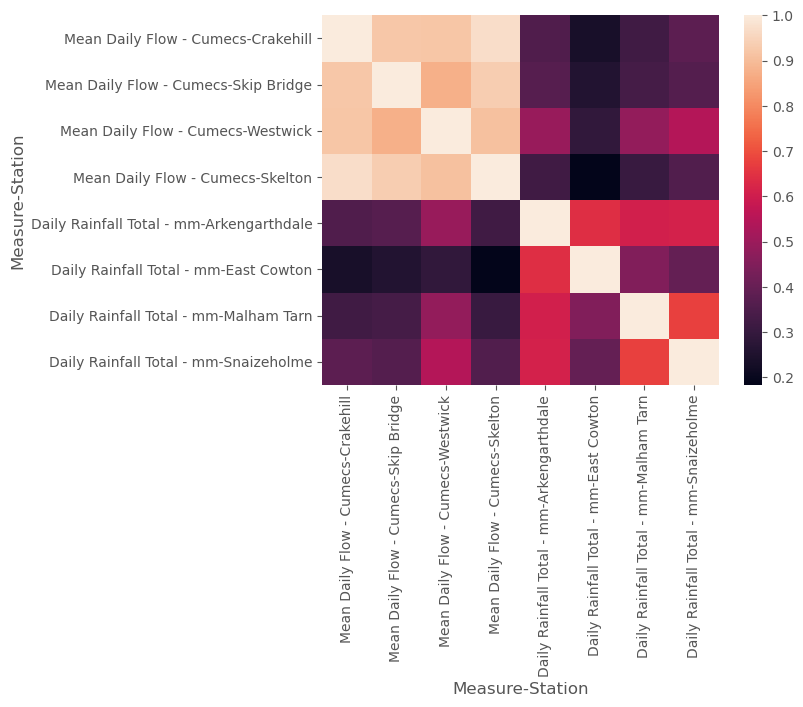

In [655]:
sns.heatmap(corr_time)

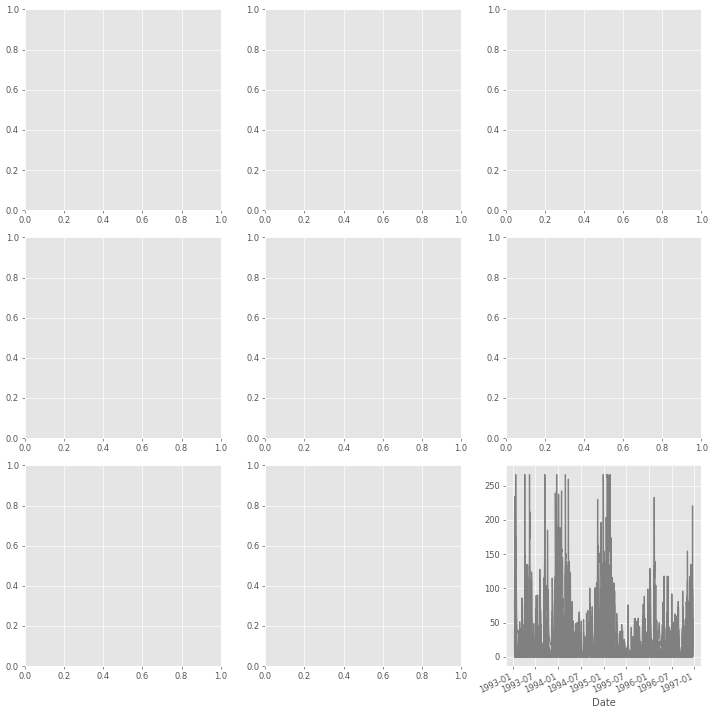

In [656]:
titles = []

column_names = df_time.columns

def visualize(data):
    datetime = data.index
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,12), dpi = 60)
    for column in range(len(column_names)):
        name = column_names[column]
        viz_data = data[name]
        viz_data.index = datetime
        ax = viz_data.plot( rot=25, color='gray')
    plt.tight_layout()

visualize(df_time)


In [657]:
datetime_list = df_time.index.strftime('%Y-%m-%d')
#print(datetime_list[40])
years_list = [i[0:4] for i in datetime_list]
unique_years = np.unique(years_list)
#unique_years
month_list = [i[5:7] for i in datetime_list]
ym_list = [i[0:7] for i in datetime_list]
day_list = [i[8:] for i in datetime_list]
#day_list

df = df_time.copy()
df["YM"] = ym_list
df["Year"] = years_list
df["Month"] = month_list
#df.head(5)

df["Year"] = pd.to_numeric(df["Year"], errors="coerce")  # Convert Year to integer
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")  # Convert Month to integer

# Convert 'YM' to a proper datetime format
df["YM"] = pd.to_datetime(df["YM"], format='%Y-%m')  # Converts "YYYY-MM" to datetime

# Verify the data types
print(df.dtypes)


Measure                    Station       
Mean Daily Flow - Cumecs   Crakehill                float64
                           Skip Bridge              float64
                           Westwick                 float64
                           Skelton                  float64
Daily Rainfall Total - mm  Arkengarthdale           float64
                           East Cowton              float64
                           Malham Tarn              float64
                           Snaizeholme              float64
YM                                           datetime64[ns]
Year                                                  int64
Month                                                 int64
dtype: object


<Axes: xlabel='Month'>

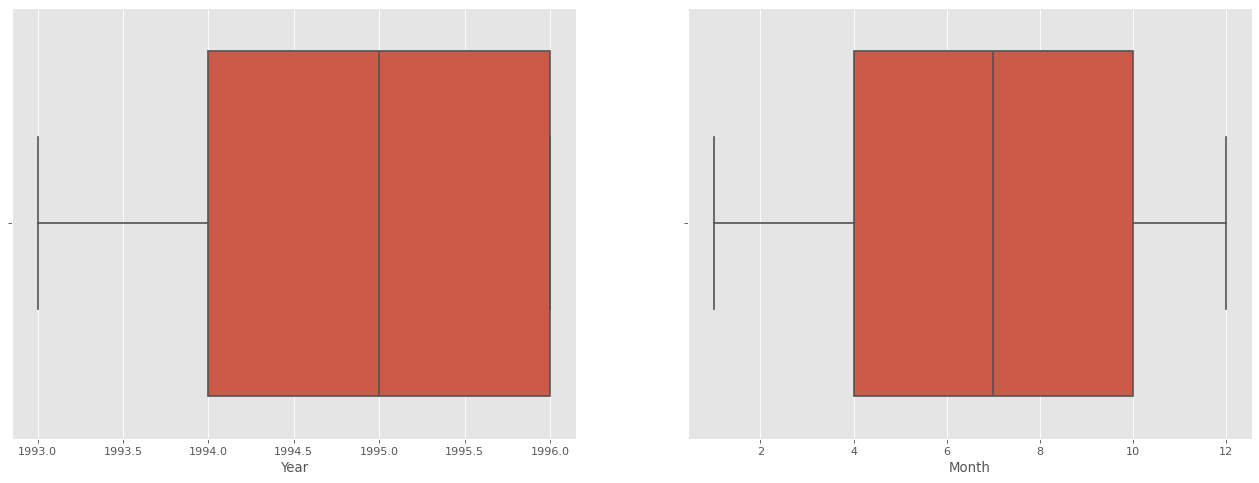

In [658]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi=80)
sns.boxplot(x=df['Year'], ax=axes[0])
sns.boxplot(x=df['Month'])

In [659]:
## This is a bit extra, dont worry about the bottom as much

<Axes: xlabel='Measure-Station', ylabel='Measure-Station'>

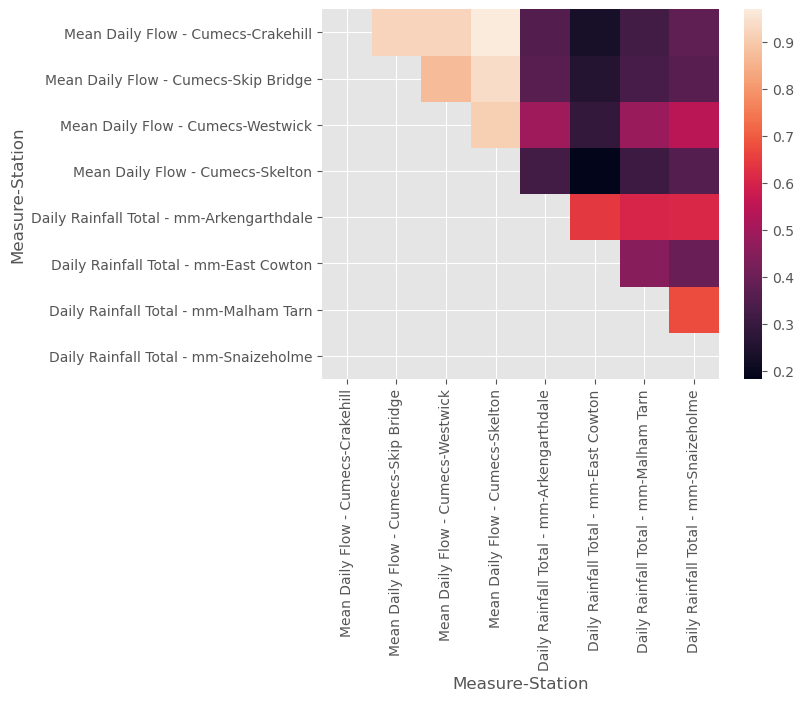

In [663]:


il = np.tril_indices(8)
triang_corr = corr_time.copy().to_numpy()
triang_corr[il] = np.nan

triang_corr = pd.DataFrame(triang_corr, columns=corr_time.columns, index = corr_time.index)
sns.heatmap(triang_corr)




In [665]:
#Lets drop eastcowtown since the correlation is way to weak to consider being useful

df_time2 = df_time.drop(columns=[('Daily Rainfall Total - mm', 'East Cowton')])

 

In [666]:
df_time2


Measure    Mean Daily Flow - Cumecs                               \
Station                   Crakehill Skip Bridge Westwick Skelton   
Date                                                               
1993-01-15                    10.40       4.393    9.291   26.10   
1993-01-15                     9.95       4.239    8.622   24.86   
1993-01-15                     9.46       4.124    8.057   23.60   
1993-01-15                     9.41       4.363    7.925   23.47   
1993-01-15                    26.30      11.962   58.704   60.70   
...                             ...         ...      ...     ...   
1996-12-17                    10.90       5.721   11.558   29.52   
1996-12-17                    11.10       5.486   11.411   28.67   
1996-12-17                    12.10       5.329   11.781   29.31   
1996-12-17                    15.80       6.177   14.255   34.28   
1996-12-17                    16.80       5.829   13.549   39.42   

Measure    Daily Rainfall Total - mm                          
Station               Arkengarthdale Malham Tarn Snaizeholme  
Date                                                          
1993-01-15                       0.0         0.0         4.0  
1993-01-15                       0.0         0.8         0.0  
1993-01-15                       0.0         0.8         0.0  
1993-01-15                       2.4         0.8        61.6  
1993-01-15                      11.2        33.6       111.2  
...                              ...         ...         ...  
1996-12-17                       1.6         8.8         3.2  
1996-12-17                      11.2         4.8         4.8  
1996-12-17                       3.2         0.0         0.8  
1996-12-17                      12.8         5.6         4.0  
1996-12-17                       4.8         6.4         0.8  

[1461 rows x 7 columns]

In [767]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_time2)
df_scaled = pd.DataFrame(scaler.fit_transform(df_time2), columns=df_time2.columns, index=df_time2.index)
df_scaled.shape


In [777]:
from sklearn.preprocessing import MinMaxScaler
target_col = ('Mean Daily Flow - Cumecs', 'Skelton')
feature_cols = df_time2.columns.difference([target_col])

# Fit a scaler for the input features (X) only
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(df_time2[feature_cols])
df_X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_time2.index)

# Fit a scaler for the target variable (y) only
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(df_time2[[target_col]])
df_y_scaled = pd.DataFrame(y_scaled, columns=[target_col], index=df_time2.index)

# Now you can construct your training data:
X = df_X_scaled.values   # Shape will be (n_samples, 6)
y = df_y_scaled.values   # Shape will be (n_samples, 1)

y = y.reshape(-1, 1)




In [672]:
## The Neural Network


# X = (Crakehill,Skip Bridge, Westwick, Arkengarthdale, Malham Tarn, Snaizeholme), y = Skelton
feature_cols = df_scaled.columns.difference([('Mean Daily Flow - Cumecs', 'Skelton')])
X = df_scaled[feature_cols].values
y = df_scaled[('Mean Daily Flow - Cumecs', 'Skelton')].values

y = y.reshape(-1, 1)



In [779]:
class NeuralNetwork:
    
    def __init__(self, input_size, hidden_sizes, output_size, activation="sigmoid", learning_rate=0.01,
                 momentum=0.0, weight_decay=0.0, annealing_rate=1.0, bold_driver_enabled=False,
                 increase_factor=1.01, decrease_factor=0.99):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.activation_name = activation
        

        # Define activation functions
        self.activation = self.get_activation_function(activation)
        self.activation_deriv = self.get_activation_derivative(activation)

        # Define layers
        self.layers = [input_size] + hidden_sizes + [output_size]
        
        # Weight initialization (Xavier Initialization)
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1 / self.layers[i]) 
                        for i in range(len(self.layers) - 1)]

        # Initialize the optimizer with the provided parameters
        self.optimizer = Optimizer(self, learning_rate, momentum, weight_decay, annealing_rate,
                                   bold_driver_enabled, increase_factor, decrease_factor)

    def get_activation_function(self, name):
        """Return the activation function corresponding to the name."""
        if name == "sigmoid":
            return lambda x: 1 / (1 + np.exp(-x))
        elif name == "relu":
            return lambda x: np.maximum(0, x)
        elif name == "tanh":
            return lambda x: np.tanh(x)
        else:
            print("Not a valid activation function")
            return None

    def get_activation_derivative(self, name):
        """Return the derivative of the activation function."""
        if name == "sigmoid":
            return lambda x: x * (1 - x) 
        elif name == "relu":
            return lambda x: (x > 0).astype(float)
        elif name == "tanh":
            return lambda x: 1 - x**2
        else:
            print("Not a valid activation function")
            return None
    
    def feedforward(self, X):
        """Perform forward propagation through the network."""
        self.a_values = [X]
        self.z_values = []
        
        for i in range(len(self.weights)):
            z = np.dot(self.a_values[-1], self.weights[i])  
            self.z_values.append(z)
            
            if i < len(self.weights) - 1:
                activation = self.activation(z)  
            else:
                if self.activation_name == "sigmoid": 
                    activation = 1 / (1 + np.exp(-np.clip(z, -500, 500)))  
                else:  
                    activation = z  
                
            self.a_values.append(activation)
        
        return self.a_values[-1]  # Return output layer activation

    def backward(self, X, y, batch_size):
        """Perform backpropagation and update weights using the optimizer."""
        output = self.a_values[-1]
        deltas = [y - output]  # Compute error at output layer
    
        # Backpropagate through hidden layers
        for i in range(len(self.weights) - 1, 0, -1):
            delta = deltas[-1].dot(self.weights[i].T) * self.activation_deriv(self.a_values[i])
            deltas.append(delta)
    
        deltas.reverse()
    
        # Compute gradients for all layers
        gradients = []
        for i in range(len(self.weights)):
            # Compute gradient and average over the mini-batch
            grad = -self.a_values[i].T.dot(deltas[i]) / batch_size  
            gradients.append(grad)
    
        # Update weights using the optimizer
        self.optimizer.update(gradients)

    def train(self, X, y, epochs=1000, batch_size=1):
        """Train the network using mini-batch SGD and record the loss."""
        self.loss_history = []
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle the dataset at the beginning of each epoch
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            n_batches = 0
            
            # Process mini-batches
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                output = self.feedforward(X_batch)
                loss = np.mean((y_batch - output) ** 2)
                epoch_loss += loss
                n_batches += 1
            
                self.backward(X_batch, y_batch, batch_size)
            
            # Record average loss for this epoch
            avg_epoch_loss = epoch_loss / n_batches
            self.loss_history.append(avg_epoch_loss)

            # Adjust learning rate using Bold Driver or annealing
            self.optimizer.adjust_learning_rate(avg_epoch_loss)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {avg_epoch_loss}")
        
        # Plot training loss over epochs
        plt.plot(range(epochs), self.loss_history)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Time")
        plt.show()
    
    def score(self, X, y):
        """Compute the R² score for the model's predictions on X compared to y."""
        predictions = self.predict(X).flatten()
        y_true = y.flatten()
        ss_res = np.sum((y_true - predictions) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

    def predict(self, X):
        """Generate predictions for the input data."""
        return self.feedforward(X)

class Optimizer:
    def __init__(self, network, learning_rate=0.01, momentum=0.0, weight_decay=0.0,
                 annealing_rate=1.0, bold_driver_enabled=False, increase_factor=1.01, decrease_factor=0.99):
        # Initialize the optimizer with various techniques to improve training.
        self.network = network
        self.learning_rate = learning_rate
        self.base_learning_rate = learning_rate  # Save the initial learning rate.
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.annealing_rate = annealing_rate  # 1.0 means no annealing.
        self.bold_driver_enabled = bold_driver_enabled
        self.increase_factor = increase_factor
        self.decrease_factor = decrease_factor
        self.epoch = 0
        self.prev_loss = None  

        # Initialize momentum velocities for each weight matrix.
        self.velocities = [np.zeros_like(w) for w in self.network.weights]

    def update(self, gradients):
        """Update the network's weights using momentum, weight decay, and the computed gradients."""
        for i in range(len(self.network.weights)):
            decay_term = self.weight_decay * self.network.weights[i]
            self.velocities[i] = self.momentum * self.velocities[i] - self.learning_rate * (gradients[i] + decay_term)
            self.network.weights[i] += self.velocities[i]

    def adjust_learning_rate(self, current_loss):
        """
        Adjust the learning rate after each epoch using:
         - Bold Driver: slightly adjust the learning rate based on loss improvement.
         - Annealing: gradually decay the learning rate.
        """
        if self.bold_driver_enabled:
            if self.prev_loss is not None:
                if current_loss > self.prev_loss:
                    self.learning_rate *= self.decrease_factor
                else:
                    self.learning_rate *= self.increase_factor
            self.prev_loss = current_loss  

        if self.annealing_rate != 1.0:
            self.epoch += 1
            self.learning_rate *= self.annealing_rate


Epoch 0: Loss = 0.05482811372871225
Epoch 100: Loss = 0.0021863584693615026
Epoch 200: Loss = 0.0021290521087641862
Epoch 300: Loss = 0.002068958901167254
Epoch 400: Loss = 0.0020044772341568286
Epoch 500: Loss = 0.0020076574866456625
Epoch 600: Loss = 0.0020119586326026056
Epoch 700: Loss = 0.001970139297305832
Epoch 800: Loss = 0.0019695756012187058
Epoch 900: Loss = 0.001930900021577321
Epoch 1000: Loss = 0.0019204736298694652
Epoch 1100: Loss = 0.0019229045411215233
Epoch 1200: Loss = 0.0019158783647988341
Epoch 1300: Loss = 0.0019115770929130794
Epoch 1400: Loss = 0.0018998009796683023
Epoch 1500: Loss = 0.0018910262370158688
Epoch 1600: Loss = 0.0018956044233168633
Epoch 1700: Loss = 0.0018853076757818093
Epoch 1800: Loss = 0.0018675357966255878
Epoch 1900: Loss = 0.0018827690904154953


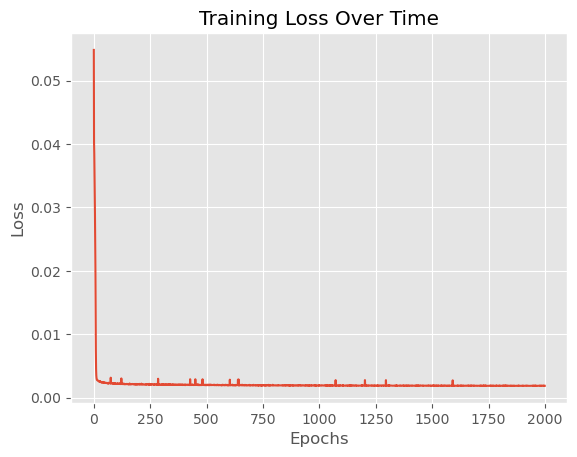

Training R² Score: 0.9546
Validation R² Score: 0.9617
The model generalizes well between training and validation data.


In [675]:
# Assuming ANN is an instance of NeuralNetwork after training:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the NeuralNetwork with a specific architecture and optimization parameters.
ANN = NeuralNetwork(
    input_size=6, 
    hidden_sizes=[8, 8],  # Example architecture with two hidden layers, each with 8 nodes.
    output_size=1, 
    activation="sigmoid", 
    learning_rate=0.1,
    momentum=0.9, 
    weight_decay=0.0001, 
    annealing_rate=0.999, 
    bold_driver_enabled=False
)

# Train the network.
ANN.train(X_train, y_train, epochs=2000, batch_size=20)
# Compute R² scores for training and validation data
train_score = ANN.score(X_train, y_train)
val_score = ANN.score(X_val, y_val)

print(f"Training R² Score: {train_score:.4f}")
print(f"Validation R² Score: {val_score:.4f}")

# You can then compare the scores:
if train_score > val_score:
    print("The model performs better on training data than on validation data. This gap might indicate overfitting.")
else:
    print("The model generalizes well between training and validation data.")


In [559]:
class Optimizer:
    def __init__(self, network, learning_rate=0.01, momentum=0.0, weight_decay=0.0,
                 annealing_rate=1.0, bold_driver_enabled=False, increase_factor=1.05, decrease_factor=0.7):
        # Initialize the optimizer with various techniques to improve training.
        # network: the neural network whose weights will be updated.
        # learning_rate: the basic step size for updating weights.
        # momentum: helps smooth out updates by adding a fraction of the previous update.
        # weight_decay: applies L2 regularization to keep weights small.
        # annealing_rate: gradually decreases the learning rate over time (1.0 means it stays the same).
        # bold_driver_enabled: if enabled, the learning rate will adjust based on how the loss changes.
        # increase_factor: how much to boost the learning rate when the loss gets better.
        # decrease_factor: how much to reduce the learning rate when the loss gets worse.
        self.network = network
        self.learning_rate = learning_rate
        self.base_learning_rate = learning_rate  # Save the original learning rate for reference.
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.annealing_rate = annealing_rate  # A factor of 1.0 means no learning rate decay.
        self.bold_driver_enabled = bold_driver_enabled
        self.increase_factor = increase_factor
        self.decrease_factor = decrease_factor
        self.epoch = 0
        self.prev_loss = None  

        self.velocities = [np.zeros_like(w) for w in self.network.weights]

    def update(self, gradients):
        # Update each of the network's weight matrices using the provided gradients.
        # This update takes into account weight decay  and momentum.
        for i in range(len(self.network.weights)):
            decay_term = self.weight_decay * self.network.weights[i]
            self.velocities[i] = self.momentum * self.velocities[i] - self.learning_rate * (gradients[i] + decay_term)
            self.network.weights[i] += self.velocities[i]

    def adjust_learning_rate(self, current_loss):
        # Adjust the learning rate after each epoch using two methods:
        # 1. Bold Driver: change the learning rate based on whether the loss improved or worsened. 
        #If the current loss is higher than the previous loss, we reduce the learning rate.
        #If the loss improved, we increase it slightly.
        # Annealing: slowly reduce the learning rate by multiplying it by the annealing_rate.
        if self.bold_driver_enabled:
            if self.prev_loss is not None:
                if current_loss > self.prev_loss:
                    self.learning_rate *= self.decrease_factor
                else:
                    self.learning_rate *= self.increase_factor
            self.prev_loss = current_loss  


        if self.annealing_rate != 1.0:
            self.epoch += 1  # Count the epochs.
            self.learning_rate *= self.annealing_rate


Epoch 0: Loss = 0.05052999585208912
Epoch 100: Loss = 0.0023543033458270006
Epoch 200: Loss = 0.002224441311192867
Epoch 300: Loss = 0.002118233492166752
Epoch 400: Loss = 0.001975614546918466
Epoch 500: Loss = 0.0018763667749668682
Epoch 600: Loss = 0.0018112646386515912
Epoch 700: Loss = 0.0017788476088608208
Epoch 800: Loss = 0.0016866133257054017
Epoch 900: Loss = 0.0016458751094961166
Epoch 1000: Loss = 0.0016165018053322215
Epoch 1100: Loss = 0.0015931883829684577
Epoch 1200: Loss = 0.001546512348242283
Epoch 1300: Loss = 0.0014922220321207501
Epoch 1400: Loss = 0.0014755193115206398
Epoch 1500: Loss = 0.0014683966147227788
Epoch 1600: Loss = 0.0014576591115707978
Epoch 1700: Loss = 0.0014364514047842222
Epoch 1800: Loss = 0.0014277282250550465
Epoch 1900: Loss = 0.0014493462563964017
Epoch 2000: Loss = 0.0014220942550862302
Epoch 2100: Loss = 0.0014175903590473654
Epoch 2200: Loss = 0.0014116160433520837
Epoch 2300: Loss = 0.0014061127446153095
Epoch 2400: Loss = 0.0013802550400

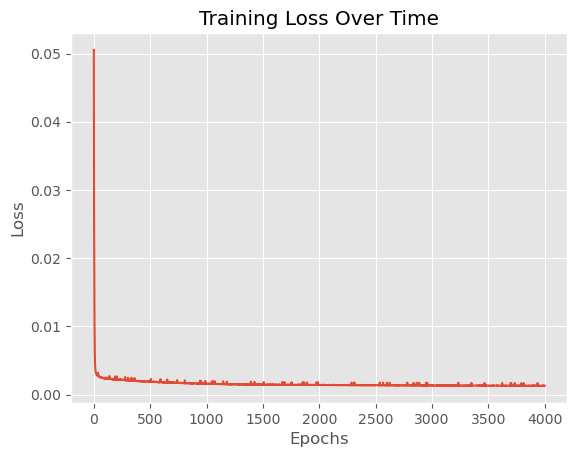

[[0.07603349]
 [0.06958542]
 [0.06391581]
 ...
 [0.102055  ]
 [0.13094814]
 [0.13811494]]
7.147000789642334


In [681]:
#Using dataset
import time
# Binary Classification (0 or 1 output)
ANN = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.5)

# Regression (continuous output)
#ANN = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="relu", learning_rate=0.01)
start = time.time()
ANN.train(X, y, epochs=4000, batch_size=40)

print(ANN.predict(X))
end = time.time()
print(end - start)


In [298]:
print(y)
scaler.inverse_transform(y) 

[[0.08344509]
 [0.07870758]
 [0.07389366]
 ...
 [0.09570912]
 [0.11469735]
 [0.13433509]]


ValueError: non-broadcastable output operand with shape (1461,1) doesn't match the broadcast shape (1461,7)

Training Base Neural Network...

Epoch 0: Loss = 0.01948496815268943
Epoch 100: Loss = 0.0016037587518096985
Epoch 200: Loss = 0.0016057103464814447
Epoch 300: Loss = 0.001527452681853412
Epoch 400: Loss = 0.0013995533920974019
Epoch 500: Loss = 0.0015468608082021564
Epoch 600: Loss = 0.0016098729788194958
Epoch 700: Loss = 0.0016378663774992207
Epoch 800: Loss = 0.0017725246464693055
Epoch 900: Loss = 0.00152282088016534
Epoch 1000: Loss = 0.00151343031821327
Epoch 1100: Loss = 0.0014722967828951698
Epoch 1200: Loss = 0.0021921970850247814
Epoch 1300: Loss = 0.001717334675856437
Epoch 1400: Loss = 0.0016683634879023357
Epoch 1500: Loss = 0.0021465812476250297
Epoch 1600: Loss = 0.0015880288554200059
Epoch 1700: Loss = 0.0016257180862416845
Epoch 1800: Loss = 0.0014361858064979125
Epoch 1900: Loss = 0.0020282199928786473
Epoch 2000: Loss = 0.0016611210791974461
Epoch 2100: Loss = 0.001666964340553582
Epoch 2200: Loss = 0.0015156264835874214
Epoch 2300: Loss = 0.0018792252312458855
Epoc

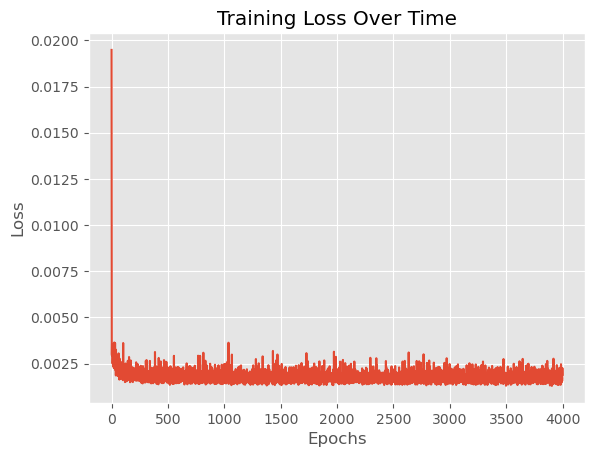

Base Network Predictions:
 [[0.08167506]
 [0.07587345]
 [0.07060446]
 ...
 [0.10348517]
 [0.12680981]
 [0.13504009]]
Base Training Time: 5.60 seconds

Training Optimized Neural Network...

Epoch 0: Loss = 0.018925330581593104
Epoch 100: Loss = 0.0019265542885681716
Epoch 200: Loss = 0.0019342116723702408
Epoch 300: Loss = 0.0017966493689350275
Epoch 400: Loss = 0.0025135457474836924
Epoch 500: Loss = 0.0015941377414951787
Epoch 600: Loss = 0.0015359807995518164
Epoch 700: Loss = 0.0015626927775741933
Epoch 800: Loss = 0.002080299119820041
Epoch 900: Loss = 0.001979515765009521
Epoch 1000: Loss = 0.0017619775756182881
Epoch 1100: Loss = 0.001608480371331693
Epoch 1200: Loss = 0.001804620110143268
Epoch 1300: Loss = 0.0014267609139834486
Epoch 1400: Loss = 0.0017992093887040188
Epoch 1500: Loss = 0.0015771306722157296
Epoch 1600: Loss = 0.0015743853279882724
Epoch 1700: Loss = 0.001357562668701765
Epoch 1800: Loss = 0.002316010879762487
Epoch 1900: Loss = 0.0017853441695191974
Epoch 2000

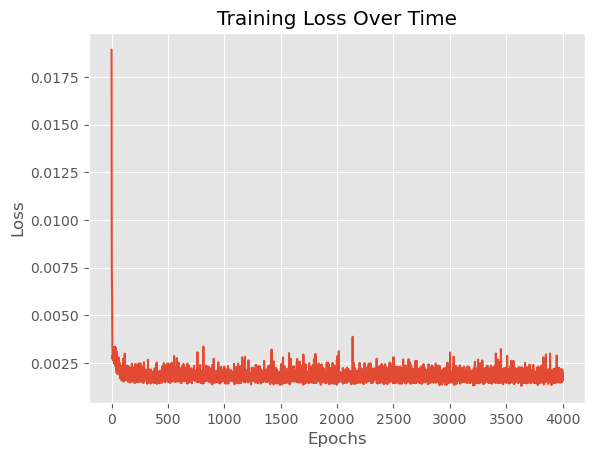

Optimized Network Predictions:
 [[0.07741815]
 [0.07246364]
 [0.06741077]
 ...
 [0.09809424]
 [0.11955225]
 [0.12843836]]
Optimized Training Time: 5.58 seconds


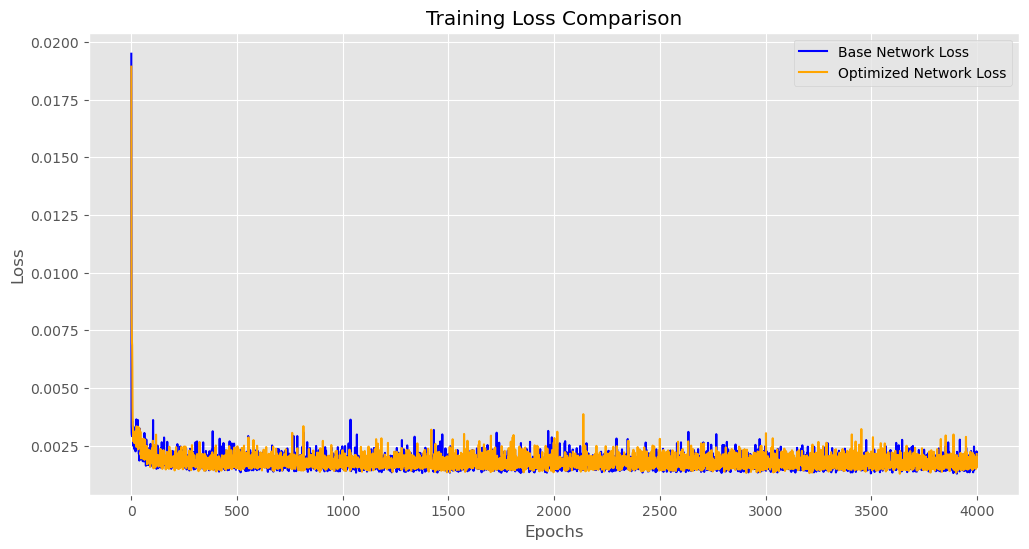

In [573]:
# ----- Base Network Training -----
print("Training Base Neural Network...\n")
ANN_base = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.5)

start_base = time.time()
ANN_base.train(X, y, epochs=4000, batch_size=40)
end_base = time.time()

print("Base Network Predictions:\n", ANN_base.predict(X))
print("Base Training Time: {:.2f} seconds".format(end_base - start_base))
print()

# ----- Optimized Network Training -----
print("Training Optimized Neural Network...\n")
ANN_opt = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.5,
                        momentum=0.9, weight_decay=0.0001, annealing_rate=0.999, bold_driver_enabled=True)

start_opt = time.time()
ANN_opt.train(X, y, epochs=4000, batch_size=40)
end_opt = time.time()

print("Optimized Network Predictions:\n", ANN_opt.predict(X))
print("Optimized Training Time: {:.2f} seconds".format(end_opt - start_opt))

# ----- Comparison of Loss History -----
plt.figure(figsize=(12, 6))
plt.plot(ANN_base.loss_history, label='Base Network Loss', color='blue')
plt.plot(ANN_opt.loss_history, label='Optimized Network Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

Training Base Neural Network...

Epoch 0: Loss = 0.01394324460334445
Epoch 100: Loss = 0.0016512270509863257
Epoch 200: Loss = 0.0014744563663180645
Epoch 300: Loss = 0.0015652610884416289
Epoch 400: Loss = 0.0015261345771681511
Epoch 500: Loss = 0.0014029614239156503
Epoch 600: Loss = 0.0013961177687532612
Epoch 700: Loss = 0.0013666751958728341
Epoch 800: Loss = 0.0014445534208371198
Epoch 900: Loss = 0.0015789966942693309
Epoch 1000: Loss = 0.0014739264183854894
Epoch 1100: Loss = 0.0013458493185546086
Epoch 1200: Loss = 0.0014230524366715535
Epoch 1300: Loss = 0.0014758525302016562
Epoch 1400: Loss = 0.001446676043065371
Epoch 1500: Loss = 0.0014883231726605338
Epoch 1600: Loss = 0.001672781780499914
Epoch 1700: Loss = 0.0014294610962608753
Epoch 1800: Loss = 0.001329154525519065
Epoch 1900: Loss = 0.0014919541617876744


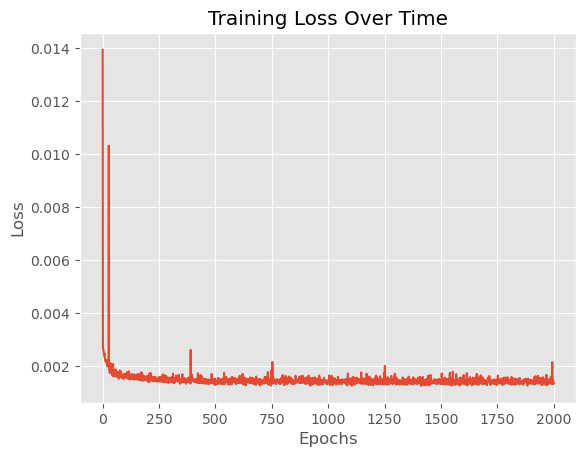

Base Network Predictions:
 [[0.08433341]
 [0.0790103 ]
 [0.07305031]
 ...
 [0.10839472]
 [0.13634544]
 [0.14388187]]
Base Training Time: 5.01 seconds

Training Optimized Neural Network...

Epoch 0: Loss = 0.04782208422727688
Epoch 100: Loss = 0.002446478662852837
Epoch 200: Loss = 0.002271908641488245
Epoch 300: Loss = 0.0021472365713954464
Epoch 400: Loss = 0.002428937100642511
Epoch 500: Loss = 0.0018885774274630001
Epoch 600: Loss = 0.00179404554537232
Epoch 700: Loss = 0.0016779437365458923
Epoch 800: Loss = 0.0016700698577259488
Epoch 900: Loss = 0.001608195528262884
Epoch 1000: Loss = 0.0015690136574441605
Epoch 1100: Loss = 0.0015649309023061846
Epoch 1200: Loss = 0.0015524720805751258
Epoch 1300: Loss = 0.0015067701361050339
Epoch 1400: Loss = 0.0014994249665463534
Epoch 1500: Loss = 0.0014817468734494334
Epoch 1600: Loss = 0.0014890746043934448
Epoch 1700: Loss = 0.0014624283077211652
Epoch 1800: Loss = 0.0015062104445641251
Epoch 1900: Loss = 0.0014531440141082358
Epoch 2000:

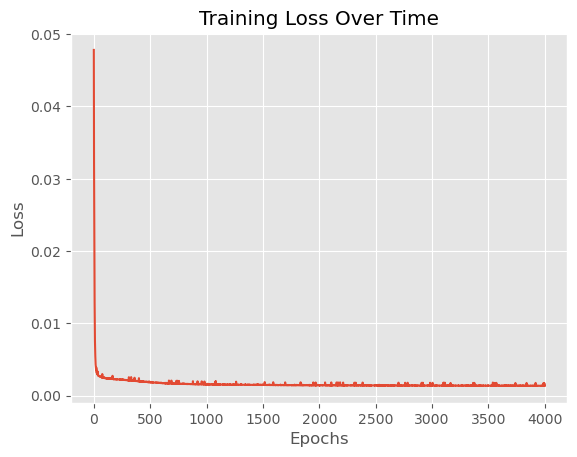

Optimized Network Predictions:
 [[0.07532384]
 [0.06903197]
 [0.0634287 ]
 ...
 [0.10165979]
 [0.1319956 ]
 [0.13904497]]
Optimized Training Time: 6.41 seconds


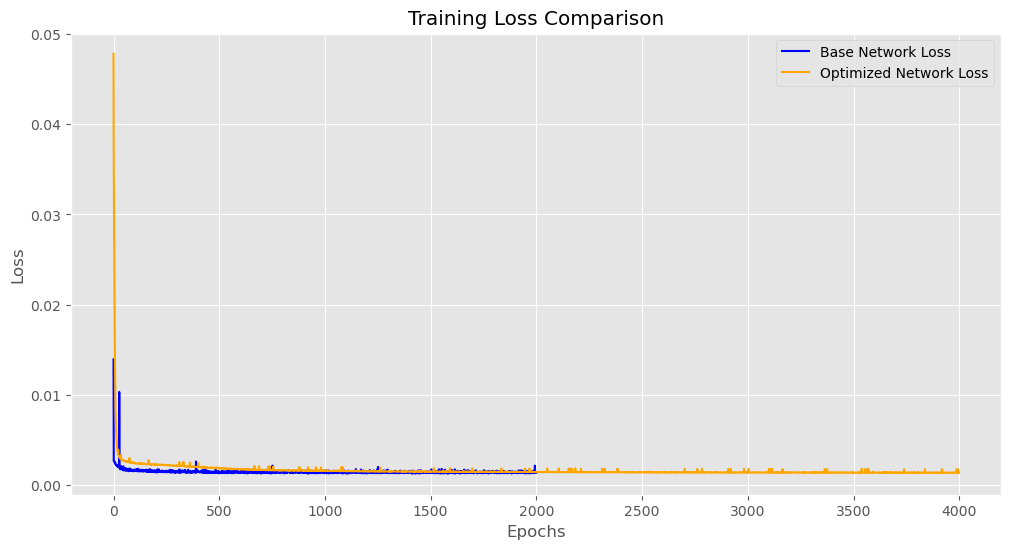

In [575]:
print("Training Base Neural Network...\n")
ANN_base = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.5)

start_base = time.time()
ANN_base.train(X, y, epochs=2000, batch_size=20)  # Fewer epochs and smaller batch size
end_base = time.time()

print("Base Network Predictions:\n", ANN_base.predict(X))
print("Base Training Time: {:.2f} seconds".format(end_base - start_base))
print()

# ----- Optimized Network Training -----
print("Training Optimized Neural Network...\n")
ANN_opt = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.01,
                        momentum=0.9, weight_decay=0.0001, annealing_rate=0.999, bold_driver_enabled=True)

start_opt = time.time()
ANN_opt.train(X, y, epochs=4000, batch_size=40)  # More epochs and larger batch size
end_opt = time.time()

print("Optimized Network Predictions:\n", ANN_opt.predict(X))
print("Optimized Training Time: {:.2f} seconds".format(end_opt - start_opt))

# ----- Comparison of Loss History -----
plt.figure(figsize=(12, 6))
plt.plot(ANN_base.loss_history, label='Base Network Loss', color='blue')
plt.plot(ANN_opt.loss_history, label='Optimized Network Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


Training Base Neural Network...

Epoch 0: Loss = 0.06971374813960461
Epoch 100: Loss = 0.0028670112575504177
Epoch 200: Loss = 0.002589918562502551
Epoch 300: Loss = 0.002384132265803492
Epoch 400: Loss = 0.0023023230057650167
Epoch 500: Loss = 0.002277440710157316
Epoch 600: Loss = 0.002256108119610796
Epoch 700: Loss = 0.0023874660057161467
Epoch 800: Loss = 0.002122236677257391
Epoch 900: Loss = 0.002066526941380463
Epoch 1000: Loss = 0.002087656959835702
Epoch 1100: Loss = 0.0019610010754386774
Epoch 1200: Loss = 0.001916655234891327
Epoch 1300: Loss = 0.0018786519208114402
Epoch 1400: Loss = 0.0019310275240630177
Epoch 1500: Loss = 0.001801266867012345
Epoch 1600: Loss = 0.0017659754853927162
Epoch 1700: Loss = 0.0017290096181074937
Epoch 1800: Loss = 0.00169957962269097
Epoch 1900: Loss = 0.0016670990090587156


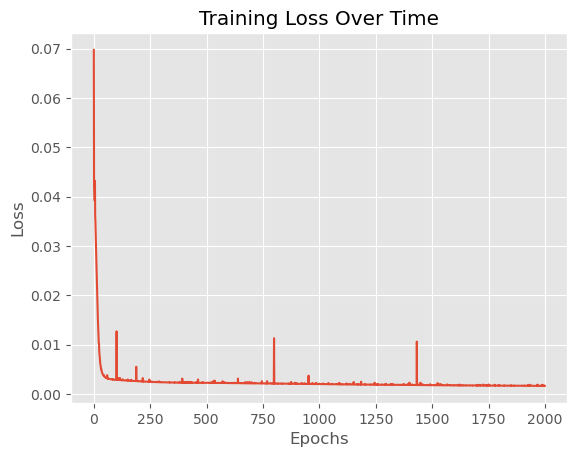

Base Network Predictions:
 [[0.06568449]
 [0.06118334]
 [0.05748953]
 ...
 [0.08504946]
 [0.11534047]
 [0.11781098]]
Base Training Time: 6.50 seconds

Training Neural Network with Momentum...

Epoch 0: Loss = 0.045474943409611675
Epoch 100: Loss = 0.0018533828665802793
Epoch 200: Loss = 0.0015731129603048948
Epoch 300: Loss = 0.0015061012006755848
Epoch 400: Loss = 0.0014448352952258817
Epoch 500: Loss = 0.0014230859463720772
Epoch 600: Loss = 0.0013589118418383252
Epoch 700: Loss = 0.001347817089402454
Epoch 800: Loss = 0.001328694986734781
Epoch 900: Loss = 0.0012999179973458347
Epoch 1000: Loss = 0.0013016736710172944
Epoch 1100: Loss = 0.0012750121015920677
Epoch 1200: Loss = 0.001259864511917295
Epoch 1300: Loss = 0.0013324384245258286
Epoch 1400: Loss = 0.0013751783585858126
Epoch 1500: Loss = 0.001279279874961931
Epoch 1600: Loss = 0.0012538598470590832
Epoch 1700: Loss = 0.0012505610200806289
Epoch 1800: Loss = 0.0012527296646043997
Epoch 1900: Loss = 0.0012422979591905714


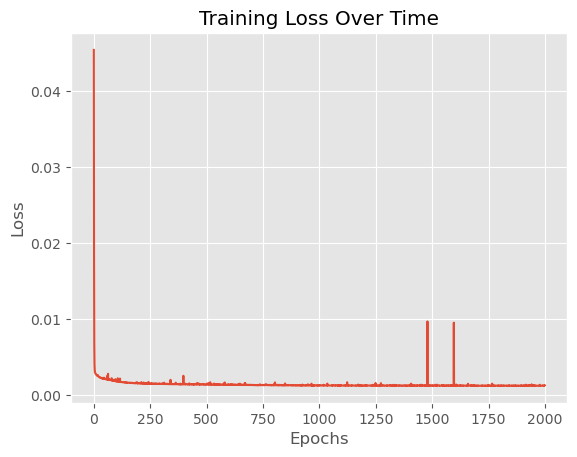

Momentum Network Predictions:
 [[0.08227733]
 [0.07546365]
 [0.06910864]
 ...
 [0.10979746]
 [0.13656834]
 [0.14489394]]
Momentum Training Time: 6.74 seconds

Training Neural Network with Weight Decay...

Epoch 0: Loss = 0.05024767744491228
Epoch 100: Loss = 0.002616998928595017
Epoch 200: Loss = 0.0023139014982948066
Epoch 300: Loss = 0.0021923722544247323
Epoch 400: Loss = 0.0021526305227999925
Epoch 500: Loss = 0.0021058882706758916
Epoch 600: Loss = 0.00211107863447542
Epoch 700: Loss = 0.0020723807538952877
Epoch 800: Loss = 0.002080874527264733
Epoch 900: Loss = 0.0020468418248956524
Epoch 1000: Loss = 0.002041984637409767
Epoch 1100: Loss = 0.002106341039922214
Epoch 1200: Loss = 0.002021758857184371
Epoch 1300: Loss = 0.0020193751984591835
Epoch 1400: Loss = 0.002015017271099615
Epoch 1500: Loss = 0.002052185409133123
Epoch 1600: Loss = 0.0020031693107168264
Epoch 1700: Loss = 0.0020017270110636266
Epoch 1800: Loss = 0.001992121318254256
Epoch 1900: Loss = 0.001995271907397412


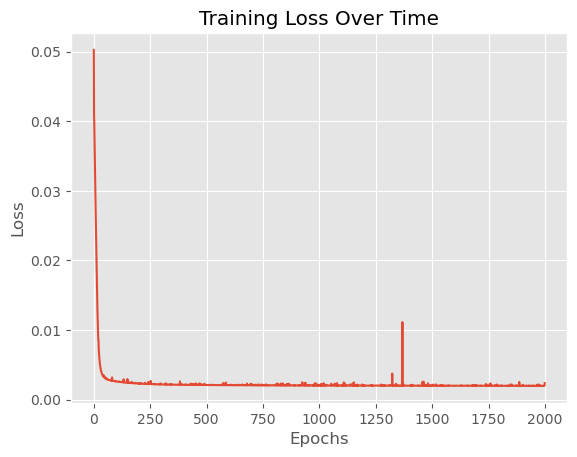

Weight Decay Network Predictions:
 [[0.0662769 ]
 [0.06302444]
 [0.06037385]
 ...
 [0.07900222]
 [0.09800963]
 [0.10068298]]
Weight Decay Training Time: 6.61 seconds

Training Neural Network with Learning Rate Annealing...

Epoch 0: Loss = 0.056710852552045665
Epoch 100: Loss = 0.0024955190572892813
Epoch 200: Loss = 0.002270923478380131
Epoch 300: Loss = 0.002162386110145002
Epoch 400: Loss = 0.0021022850635204846
Epoch 500: Loss = 0.0020393629919323317
Epoch 600: Loss = 0.001995508362540492
Epoch 700: Loss = 0.001953726352872351
Epoch 800: Loss = 0.0019235299000623948
Epoch 900: Loss = 0.0019098545746337023
Epoch 1000: Loss = 0.0018843768205819675
Epoch 1100: Loss = 0.00184619920944678
Epoch 1200: Loss = 0.0018477389157042902
Epoch 1300: Loss = 0.001812386563176299
Epoch 1400: Loss = 0.001805302370039525
Epoch 1500: Loss = 0.001790129974177378
Epoch 1600: Loss = 0.0017931649158242568
Epoch 1700: Loss = 0.0018186677251287038
Epoch 1800: Loss = 0.0017640898808681208
Epoch 1900: Loss = 

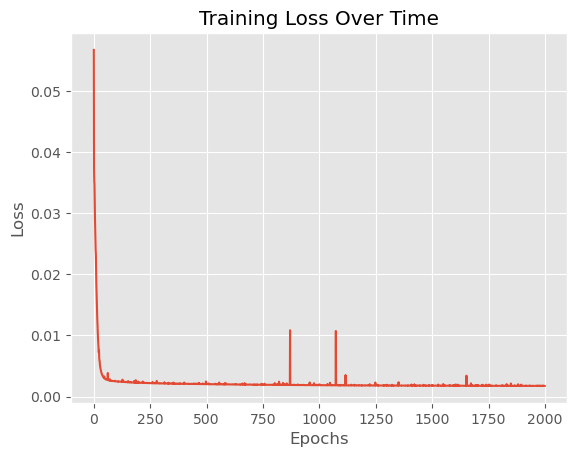

Annealing Network Predictions:
 [[0.06440993]
 [0.06034449]
 [0.05708627]
 ...
 [0.08194469]
 [0.11064325]
 [0.11118502]]
Annealing Training Time: 6.67 seconds

Training Neural Network with Bold Driver...

Epoch 0: Loss = 0.07295304030176256
Epoch 100: Loss = 0.0024921419108234854
Epoch 200: Loss = 0.0023146412663253473
Epoch 300: Loss = 0.002165325965675119
Epoch 400: Loss = 0.001973137060211849
Epoch 500: Loss = 0.00178046095505987
Epoch 600: Loss = 0.0016720782638788864
Epoch 700: Loss = 0.0015836513087098836
Epoch 800: Loss = 0.0015370888232871314
Epoch 900: Loss = 0.0015047619159924246
Epoch 1000: Loss = 0.0015375520170700034
Epoch 1100: Loss = 0.0014517668538076463
Epoch 1200: Loss = 0.0014424237404850185
Epoch 1300: Loss = 0.001441522454122273
Epoch 1400: Loss = 0.001415342192736605
Epoch 1500: Loss = 0.0014948865941728036
Epoch 1600: Loss = 0.0014286042592107486
Epoch 1700: Loss = 0.0013937566170217847
Epoch 1800: Loss = 0.0013633416100143556
Epoch 1900: Loss = 0.00135003084031

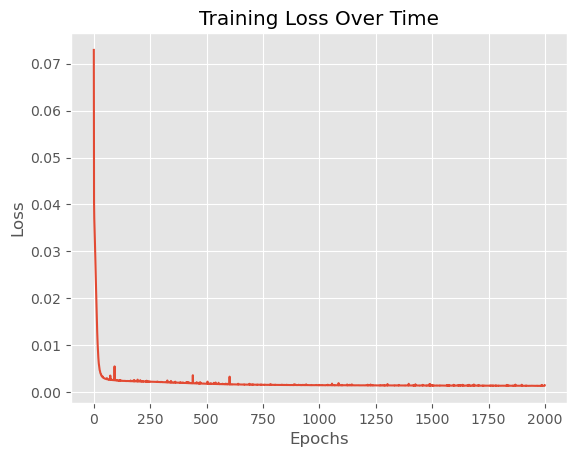

Bold Driver Network Predictions:
 [[0.07558181]
 [0.06916261]
 [0.06343903]
 ...
 [0.10188916]
 [0.13271135]
 [0.13961196]]
Bold Driver Training Time: 10.83 seconds



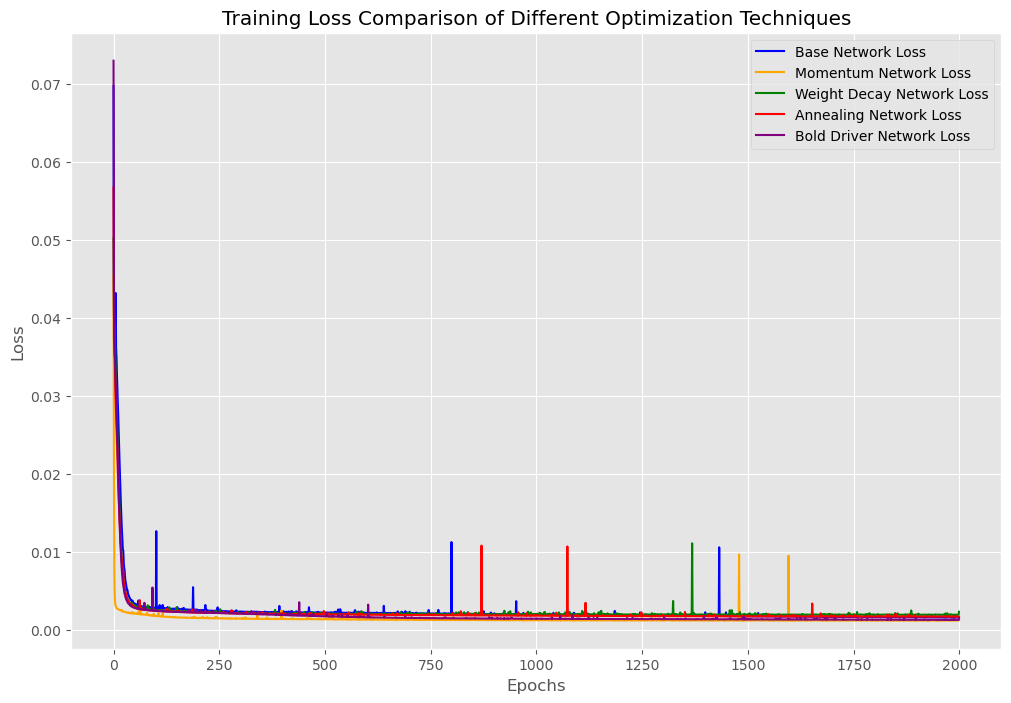

In [587]:
# ----- Base Network Training -----
print("Training Base Neural Network...\n")
ANN_base = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.1)

start_base = time.time()
ANN_base.train(X, y, epochs=2000, batch_size=20)
end_base = time.time()

print("Base Network Predictions:\n", ANN_base.predict(X))
print("Base Training Time: {:.2f} seconds".format(end_base - start_base))
print()

# ----- Network with Momentum -----
print("Training Neural Network with Momentum...\n")
ANN_momentum = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.1,
                             momentum=0.9)

start_momentum = time.time()
ANN_momentum.train(X, y, epochs=2000, batch_size=20)
end_momentum = time.time()

print("Momentum Network Predictions:\n", ANN_momentum.predict(X))
print("Momentum Training Time: {:.2f} seconds".format(end_momentum - start_momentum))
print()

# ----- Network with Weight Decay -----
print("Training Neural Network with Weight Decay...\n")
ANN_weight_decay = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.1,
                                 weight_decay=0.0001)

start_weight_decay = time.time()
ANN_weight_decay.train(X, y, epochs=2000, batch_size=20)
end_weight_decay = time.time()

print("Weight Decay Network Predictions:\n", ANN_weight_decay.predict(X))
print("Weight Decay Training Time: {:.2f} seconds".format(end_weight_decay - start_weight_decay))
print()

# ----- Network with Learning Rate Annealing -----
print("Training Neural Network with Learning Rate Annealing...\n")
ANN_annealing = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.1,
                              annealing_rate=0.999)

start_annealing = time.time()
ANN_annealing.train(X, y, epochs=2000, batch_size=20)
end_annealing = time.time()

print("Annealing Network Predictions:\n", ANN_annealing.predict(X))
print("Annealing Training Time: {:.2f} seconds".format(end_annealing - start_annealing))
print()

# ----- Network with Bold Driver -----
print("Training Neural Network with Bold Driver...\n")
ANN_bold_driver = NeuralNetwork(input_size=6, hidden_sizes=[8], output_size=1, activation="sigmoid", learning_rate=0.1,
                                bold_driver_enabled=True)

start_bold_driver = time.time()
ANN_bold_driver.train(X, y, epochs=2000, batch_size=20)
end_bold_driver = time.time()

print("Bold Driver Network Predictions:\n", ANN_bold_driver.predict(X))
print("Bold Driver Training Time: {:.2f} seconds".format(end_bold_driver - start_bold_driver))
print()

# ----- Comparison of Loss History -----
plt.figure(figsize=(12, 8))
plt.plot(ANN_base.loss_history, label='Base Network Loss', color='blue')
plt.plot(ANN_momentum.loss_history, label='Momentum Network Loss', color='orange')
plt.plot(ANN_weight_decay.loss_history, label='Weight Decay Network Loss', color='green')
plt.plot(ANN_annealing.loss_history, label='Annealing Network Loss', color='red')
plt.plot(ANN_bold_driver.loss_history, label='Bold Driver Network Loss', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison of Different Optimization Techniques")
plt.legend()
plt.show()

Base Network - Validation Loss: 0.0014, Pearson Correlation: 0.9841


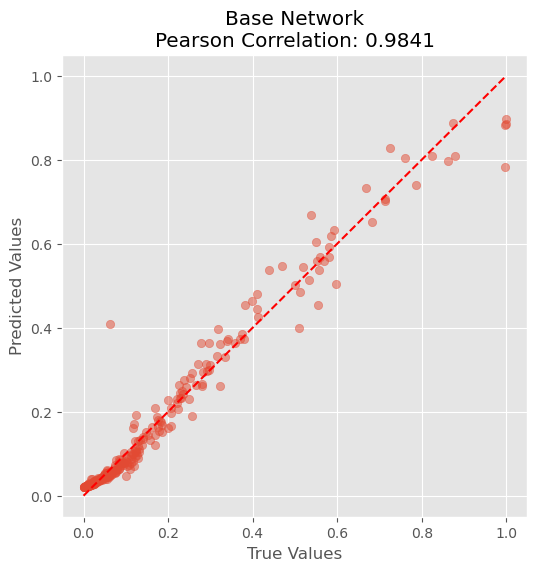

NameError: name 'ANN_optimized' is not defined

In [601]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assume X and y have been defined and scaled appropriately.
# Split your data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to compute mean squared error on the validation set.
def compute_loss(model, X_val, y_val):
    predictions = model.predict(X_val)
    return np.mean((y_val - predictions) ** 2)

# Define a function to compute Pearson correlation coefficient.
def compute_correlation(model, X_val, y_val):
    predictions = model.predict(X_val).flatten()
    y_true = y_val.flatten()
    return np.corrcoef(y_true, predictions)[0, 1]

# Define a function to plot a scatter (correlation) plot.
def plot_corr(model, X_val, y_val, title):
    predictions = model.predict(X_val).flatten()
    y_true = y_val.flatten()
    corr_coef = np.corrcoef(y_true, predictions)[0, 1]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, predictions, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{title}\nPearson Correlation: {corr_coef:.4f}")
    # Diagonal line: perfect predictions.
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.show()

# After training your models (for example, ANN_base and ANN_optimized), you can validate like so:

# For the Base Network:
base_val_loss = compute_loss(ANN_base, X_val, y_val)
base_corr = compute_correlation(ANN_base, X_val, y_val)
print(f"Base Network - Validation Loss: {base_val_loss:.4f}, Pearson Correlation: {base_corr:.4f}")
plot_corr(ANN_base, X_val, y_val, "Base Network")

# For the Optimized Network:
opt_val_loss = compute_loss(ANN_optimized, X_val, y_val)
opt_corr = compute_correlation(ANN_optimized, X_val, y_val)
print(f"Optimized Network - Validation Loss: {opt_val_loss:.4f}, Pearson Correlation: {opt_corr:.4f}")
plot_corr(ANN_optimized, X_val, y_val, "Optimized Network")


Training optimized network with hidden layers: [4]
Epoch 0: Loss = 0.0319337085258528
Epoch 100: Loss = 0.0020456066084541553
Epoch 200: Loss = 0.0019336755148530477
Epoch 300: Loss = 0.0019691169187108734
Epoch 400: Loss = 0.0019467218919617807
Epoch 500: Loss = 0.0019651926866056124
Epoch 600: Loss = 0.0019562951059654585
Epoch 700: Loss = 0.001946134317203646
Epoch 800: Loss = 0.0019138006246912317
Epoch 900: Loss = 0.0019139212252365138
Epoch 1000: Loss = 0.0019429000936905811
Epoch 1100: Loss = 0.0019554830518851555
Epoch 1200: Loss = 0.001927388791729046
Epoch 1300: Loss = 0.0019197283287002477
Epoch 1400: Loss = 0.0019686980590033635
Epoch 1500: Loss = 0.0019195457404499008
Epoch 1600: Loss = 0.001942407001185188
Epoch 1700: Loss = 0.0027762873844763792
Epoch 1800: Loss = 0.0019144896337943869
Epoch 1900: Loss = 0.0019225270338712084


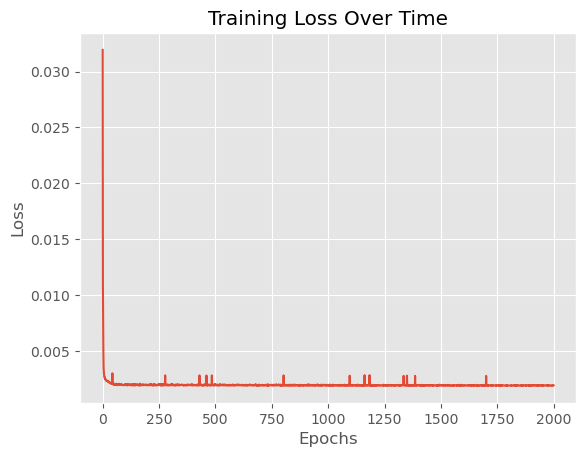

Optimized Architecture: [4] - Validation Loss: 0.0018 - Training Time: 4.99 seconds

Training optimized network with hidden layers: [8]
Epoch 0: Loss = 0.030381617457686035
Epoch 100: Loss = 0.0018788892364859598
Epoch 200: Loss = 0.00183446467345315
Epoch 300: Loss = 0.0018378450354076274
Epoch 400: Loss = 0.0018553534681400724
Epoch 500: Loss = 0.00180792699861568
Epoch 600: Loss = 0.001916436354462183
Epoch 700: Loss = 0.0018276480584418085
Epoch 800: Loss = 0.0018376851867411338
Epoch 900: Loss = 0.0018132879818275561
Epoch 1000: Loss = 0.0018270495610334303
Epoch 1100: Loss = 0.0018302172640108753
Epoch 1200: Loss = 0.0018275264037256342
Epoch 1300: Loss = 0.0018226214246619117
Epoch 1400: Loss = 0.0018209401695840242
Epoch 1500: Loss = 0.0018223909386832634
Epoch 1600: Loss = 0.0018143136414124346
Epoch 1700: Loss = 0.0018311121959212213
Epoch 1800: Loss = 0.0018142067667412528
Epoch 1900: Loss = 0.0018106587789648025


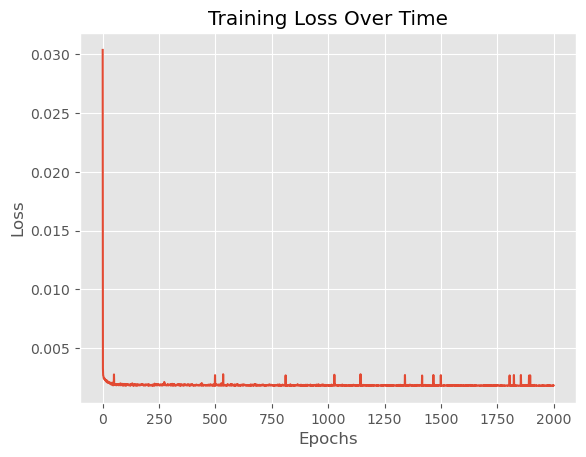

Optimized Architecture: [8] - Validation Loss: 0.0017 - Training Time: 6.23 seconds

Training optimized network with hidden layers: [16]
Epoch 0: Loss = 0.02555320826381531
Epoch 100: Loss = 0.0019102383671756535
Epoch 200: Loss = 0.001817593128468673
Epoch 300: Loss = 0.001866523812610058
Epoch 400: Loss = 0.001841471720076675
Epoch 500: Loss = 0.001857945494116974
Epoch 600: Loss = 0.00192176345202506
Epoch 700: Loss = 0.0018365802865181625
Epoch 800: Loss = 0.0017482864655858192
Epoch 900: Loss = 0.0017838821813690076
Epoch 1000: Loss = 0.001758211514557286
Epoch 1100: Loss = 0.0017997764404769868
Epoch 1200: Loss = 0.001786729067474288
Epoch 1300: Loss = 0.0018447629042647863
Epoch 1400: Loss = 0.0017851863074726864
Epoch 1500: Loss = 0.001758521313194346
Epoch 1600: Loss = 0.0017895979470904412
Epoch 1700: Loss = 0.0017668942192478499
Epoch 1800: Loss = 0.001851185058054719
Epoch 1900: Loss = 0.0017533376662094097


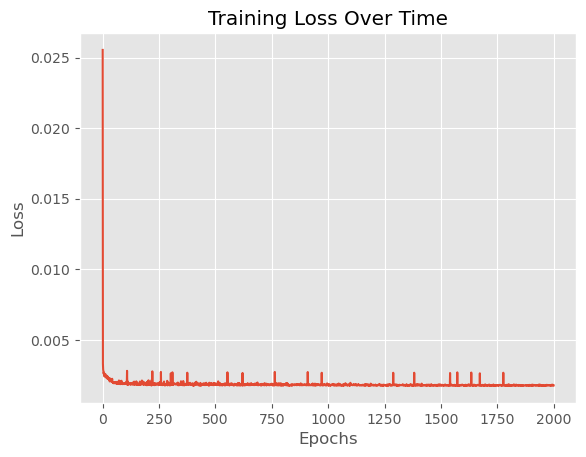

Optimized Architecture: [16] - Validation Loss: 0.0016 - Training Time: 5.34 seconds

Training optimized network with hidden layers: [4, 4]
Epoch 0: Loss = 0.043478074710253466
Epoch 100: Loss = 0.0021299488143785685
Epoch 200: Loss = 0.0021900401012483637
Epoch 300: Loss = 0.0021946420619587564
Epoch 400: Loss = 0.0023086152761419517
Epoch 500: Loss = 0.0022276777306526425
Epoch 600: Loss = 0.0022243652937091424
Epoch 700: Loss = 0.0021859355169768927
Epoch 800: Loss = 0.0022045118742861545
Epoch 900: Loss = 0.002237601939263807
Epoch 1000: Loss = 0.002179738027141096
Epoch 1100: Loss = 0.0021094443775648455
Epoch 1200: Loss = 0.002125428643349192
Epoch 1300: Loss = 0.002080860469278519
Epoch 1400: Loss = 0.0020955619323105336
Epoch 1500: Loss = 0.00210782119751109
Epoch 1600: Loss = 0.002113079454219043
Epoch 1700: Loss = 0.002106362752696949
Epoch 1800: Loss = 0.0020765807046002624
Epoch 1900: Loss = 0.002084490167651034


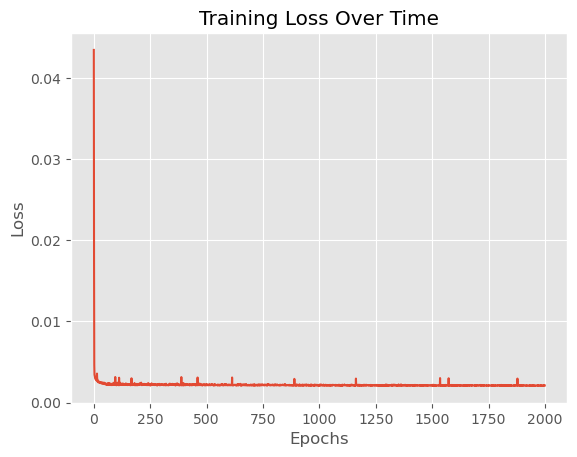

Optimized Architecture: [4, 4] - Validation Loss: 0.0020 - Training Time: 6.85 seconds

Training optimized network with hidden layers: [8, 4]
Epoch 0: Loss = 0.038714654414334256
Epoch 100: Loss = 0.0017810928611002898
Epoch 200: Loss = 0.0017005694993908695
Epoch 300: Loss = 0.0017265569447941344
Epoch 400: Loss = 0.0016800513017013712
Epoch 500: Loss = 0.0016189306643868298
Epoch 600: Loss = 0.0016817518705700121
Epoch 700: Loss = 0.0016381608222242499
Epoch 800: Loss = 0.0016659537673636702
Epoch 900: Loss = 0.0016824004423831895
Epoch 1000: Loss = 0.001651239896498259
Epoch 1100: Loss = 0.0016774845607127463
Epoch 1200: Loss = 0.0016333730957232397
Epoch 1300: Loss = 0.0016716405617678918
Epoch 1400: Loss = 0.0016276155386753394
Epoch 1500: Loss = 0.001619984277829103
Epoch 1600: Loss = 0.0016470884148254363
Epoch 1700: Loss = 0.0016253745514988405
Epoch 1800: Loss = 0.0016286604014776047
Epoch 1900: Loss = 0.0016435608612016277


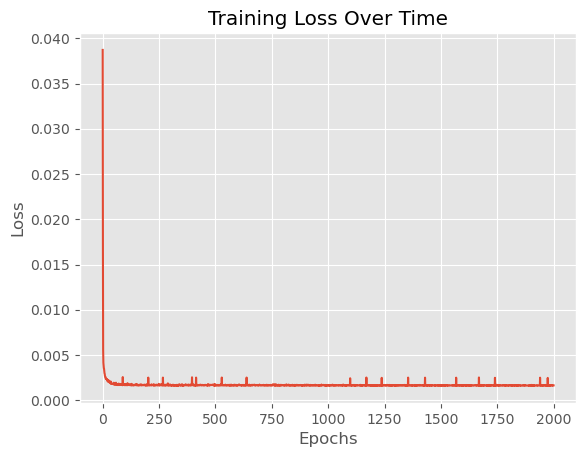

Optimized Architecture: [8, 4] - Validation Loss: 0.0015 - Training Time: 6.95 seconds

Training optimized network with hidden layers: [16, 8]
Epoch 0: Loss = 0.040611659441280666
Epoch 100: Loss = 0.002257292008172697
Epoch 200: Loss = 0.0020896352070993124
Epoch 300: Loss = 0.0019747290473458
Epoch 400: Loss = 0.0028379448673611406
Epoch 500: Loss = 0.0019117441613278824
Epoch 600: Loss = 0.0019846411221021514
Epoch 700: Loss = 0.0018547346674540799
Epoch 800: Loss = 0.0018148316247756648
Epoch 900: Loss = 0.0018480409001931752
Epoch 1000: Loss = 0.0018067556515873086
Epoch 1100: Loss = 0.0018739585358177498
Epoch 1200: Loss = 0.0018322143225118753
Epoch 1300: Loss = 0.0018324547196192176
Epoch 1400: Loss = 0.001807197345738157
Epoch 1500: Loss = 0.00179358384330762
Epoch 1600: Loss = 0.0017926804166280665
Epoch 1700: Loss = 0.0017878984001998175
Epoch 1800: Loss = 0.0017770217872766234
Epoch 1900: Loss = 0.0017501764959216431


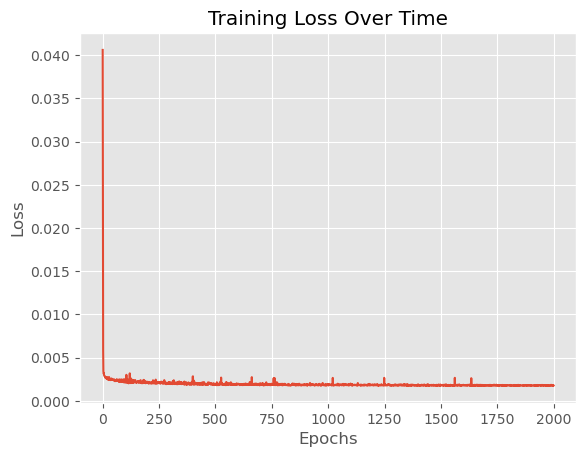

Optimized Architecture: [16, 8] - Validation Loss: 0.0016 - Training Time: 8.70 seconds

Training optimized network with hidden layers: [8, 8]
Epoch 0: Loss = 0.04285171858639501
Epoch 100: Loss = 0.002172602180277485
Epoch 200: Loss = 0.0021668356055481817
Epoch 300: Loss = 0.002091127039955774
Epoch 400: Loss = 0.002057887437413654
Epoch 500: Loss = 0.0021702842728327553
Epoch 600: Loss = 0.0020393893389735675
Epoch 700: Loss = 0.002145266953038626
Epoch 800: Loss = 0.002182656650770189
Epoch 900: Loss = 0.002079921997618801
Epoch 1000: Loss = 0.0019795212904987355
Epoch 1100: Loss = 0.001981800645850132
Epoch 1200: Loss = 0.001986836418482124
Epoch 1300: Loss = 0.0020123063962893613
Epoch 1400: Loss = 0.0019438370647957496
Epoch 1500: Loss = 0.0019511015366253399
Epoch 1600: Loss = 0.001989558605586817
Epoch 1700: Loss = 0.001929034273575478
Epoch 1800: Loss = 0.001939424884311745
Epoch 1900: Loss = 0.0019456510726594282


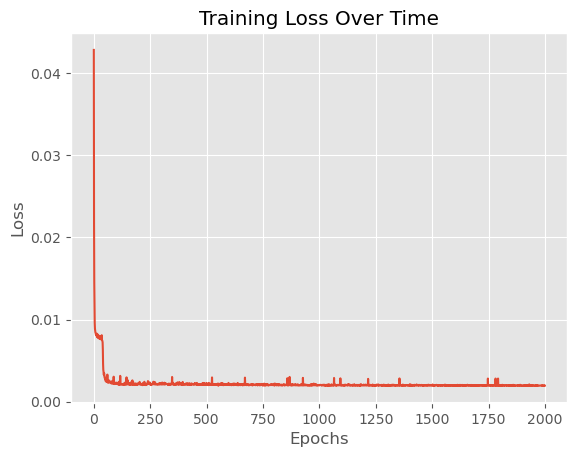

Optimized Architecture: [8, 8] - Validation Loss: 0.0018 - Training Time: 7.08 seconds

Training optimized network with hidden layers: [16, 16]
Epoch 0: Loss = 0.04354748606334857
Epoch 100: Loss = 0.0019645549656033315
Epoch 200: Loss = 0.0019440331710814133
Epoch 300: Loss = 0.0022139776603087944
Epoch 400: Loss = 0.0020334218080718942
Epoch 500: Loss = 0.0018098330439963155
Epoch 600: Loss = 0.0019644025324049423
Epoch 700: Loss = 0.0018396524894666827
Epoch 800: Loss = 0.0020330855994484596
Epoch 900: Loss = 0.0019290838362350069
Epoch 1000: Loss = 0.0018113151835220272
Epoch 1100: Loss = 0.0019457999509485836
Epoch 1200: Loss = 0.00179282685577526
Epoch 1300: Loss = 0.0018479409454037726
Epoch 1400: Loss = 0.0017930664748461466
Epoch 1500: Loss = 0.0018089773486771286
Epoch 1600: Loss = 0.0017790512014001624
Epoch 1700: Loss = 0.0017906470962888066
Epoch 1800: Loss = 0.0017806766850008125
Epoch 1900: Loss = 0.001796579375921345


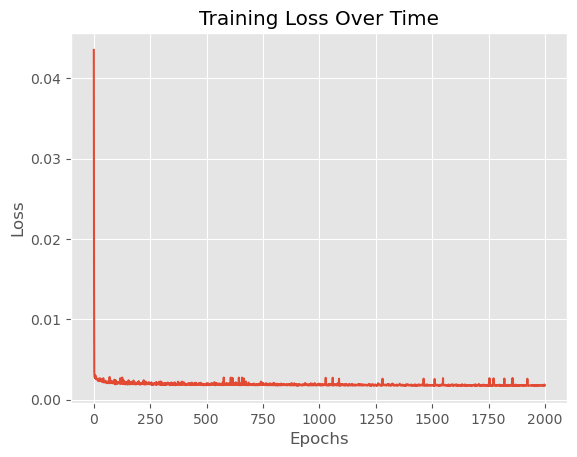

Optimized Architecture: [16, 16] - Validation Loss: 0.0018 - Training Time: 7.89 seconds

Training optimized network with hidden layers: [20, 16, 8]
Epoch 0: Loss = 0.04490703739163055
Epoch 100: Loss = 0.0017259992365655733
Epoch 200: Loss = 0.001905872920688731
Epoch 300: Loss = 0.0017031447861544098
Epoch 400: Loss = 0.0016180830398797804
Epoch 500: Loss = 0.0016294353094226212
Epoch 600: Loss = 0.0015611264224254496
Epoch 700: Loss = 0.0016206178411316214
Epoch 800: Loss = 0.001570247190342855
Epoch 900: Loss = 0.0015593920564419955
Epoch 1000: Loss = 0.0015717465940436066
Epoch 1100: Loss = 0.0015799525890160193
Epoch 1200: Loss = 0.0015912600331018797
Epoch 1300: Loss = 0.0015876499759010282
Epoch 1400: Loss = 0.0015561897009326172
Epoch 1500: Loss = 0.0015388145432045858
Epoch 1600: Loss = 0.0016079168288148271
Epoch 1700: Loss = 0.0015439404448450123
Epoch 1800: Loss = 0.0015525458717258423
Epoch 1900: Loss = 0.0015483768175534936


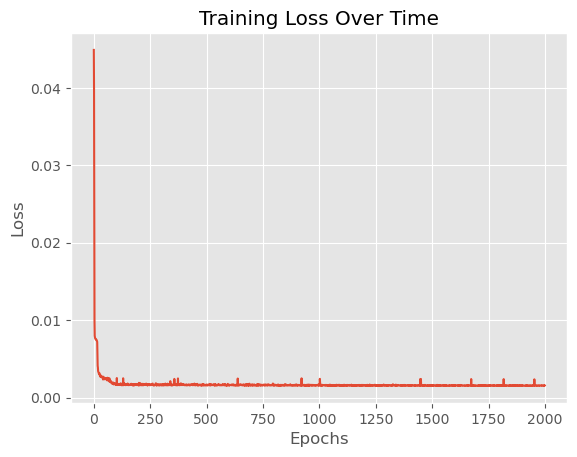

Optimized Architecture: [20, 16, 8] - Validation Loss: 0.0014 - Training Time: 10.19 seconds

Training optimized network with hidden layers: [16, 4]
Epoch 0: Loss = 0.04388398418898481
Epoch 100: Loss = 0.0017496035586157801
Epoch 200: Loss = 0.0016793290677229625
Epoch 300: Loss = 0.0016519926749151358
Epoch 400: Loss = 0.0017884456748527954
Epoch 500: Loss = 0.0017248312988982152
Epoch 600: Loss = 0.0016504787109454693
Epoch 700: Loss = 0.0017127603250978684
Epoch 800: Loss = 0.0016700482068499473
Epoch 900: Loss = 0.001712309354401783
Epoch 1000: Loss = 0.0016696639356495557
Epoch 1100: Loss = 0.0016380821771406911
Epoch 1200: Loss = 0.0016225100219687983
Epoch 1300: Loss = 0.0016507046273474203
Epoch 1400: Loss = 0.0016256861131824759
Epoch 1500: Loss = 0.0016355578756680365
Epoch 1600: Loss = 0.0016346591215463755
Epoch 1700: Loss = 0.0017296811505715384
Epoch 1800: Loss = 0.0016497985113154477
Epoch 1900: Loss = 0.0016280792312492846


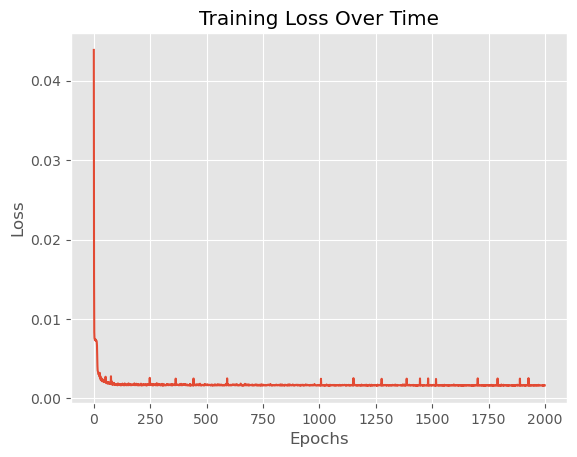

Optimized Architecture: [16, 4] - Validation Loss: 0.0016 - Training Time: 7.13 seconds

Training optimized network with hidden layers: [16, 8, 4]
Epoch 0: Loss = 0.04573129519134451
Epoch 100: Loss = 0.001675260913560353
Epoch 200: Loss = 0.001636386721716921
Epoch 300: Loss = 0.0017355453966980895
Epoch 400: Loss = 0.0017070454793281268
Epoch 500: Loss = 0.0016468768821364518
Epoch 600: Loss = 0.001643937726338788
Epoch 700: Loss = 0.0016808009603216016
Epoch 800: Loss = 0.0016618842030863064
Epoch 900: Loss = 0.0016058771071911675
Epoch 1000: Loss = 0.001635243096494751
Epoch 1100: Loss = 0.0015925511026084482
Epoch 1200: Loss = 0.00162158289151294
Epoch 1300: Loss = 0.0016039289845574567
Epoch 1400: Loss = 0.001583998362051865
Epoch 1500: Loss = 0.0016144450622897339
Epoch 1600: Loss = 0.0015855008398031327
Epoch 1700: Loss = 0.0015653321360715685
Epoch 1800: Loss = 0.0015785981361709496
Epoch 1900: Loss = 0.0016017578516895048


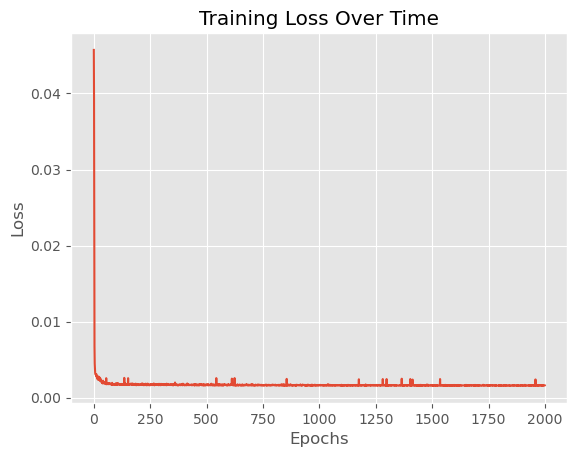

Optimized Architecture: [16, 8, 4] - Validation Loss: 0.0015 - Training Time: 9.17 seconds

Training optimized network with hidden layers: [12, 6, 4]
Epoch 0: Loss = 0.05136074827526382
Epoch 100: Loss = 0.00727345142061683
Epoch 200: Loss = 0.0073372148880267345
Epoch 300: Loss = 0.007293973053484036
Epoch 400: Loss = 0.007247986590116235
Epoch 500: Loss = 0.0073047637837012815
Epoch 600: Loss = 0.0072777855695835714
Epoch 700: Loss = 0.007458066531362477
Epoch 800: Loss = 0.007233413400346547
Epoch 900: Loss = 0.0072699242074412375
Epoch 1000: Loss = 0.0072721553337838675
Epoch 1100: Loss = 0.007240880997187068
Epoch 1200: Loss = 0.007250531407374139
Epoch 1300: Loss = 0.007268753291065702
Epoch 1400: Loss = 0.007247929289446362
Epoch 1500: Loss = 0.007352953128717035
Epoch 1600: Loss = 0.007252731929855431
Epoch 1700: Loss = 0.007559790233201053
Epoch 1800: Loss = 0.007488067629588805
Epoch 1900: Loss = 0.007227631054462229


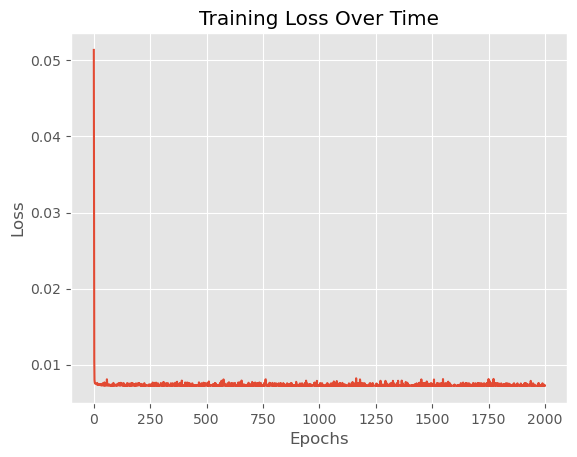

Optimized Architecture: [12, 6, 4] - Validation Loss: 0.0084 - Training Time: 9.19 seconds

Training optimized network with hidden layers: [15, 12, 6, 4]
Epoch 0: Loss = 0.05102864137672143
Epoch 100: Loss = 0.0074508690292100855
Epoch 200: Loss = 0.007390848785853517
Epoch 300: Loss = 0.007483078110216061
Epoch 400: Loss = 0.007667940802435453
Epoch 500: Loss = 0.007346850617128645
Epoch 600: Loss = 0.007443061356600176
Epoch 700: Loss = 0.007350285520980335
Epoch 800: Loss = 0.007331402413514483
Epoch 900: Loss = 0.007321432037586512
Epoch 1000: Loss = 0.007314535366920404
Epoch 1100: Loss = 0.007412759365798247
Epoch 1200: Loss = 0.007634429300417438
Epoch 1300: Loss = 0.007305075416294224
Epoch 1400: Loss = 0.007311973350616023
Epoch 1500: Loss = 0.0073196488418462045
Epoch 1600: Loss = 0.0072800341596195774
Epoch 1700: Loss = 0.0072948492614883535
Epoch 1800: Loss = 0.0073167416881910925
Epoch 1900: Loss = 0.00730442255151079


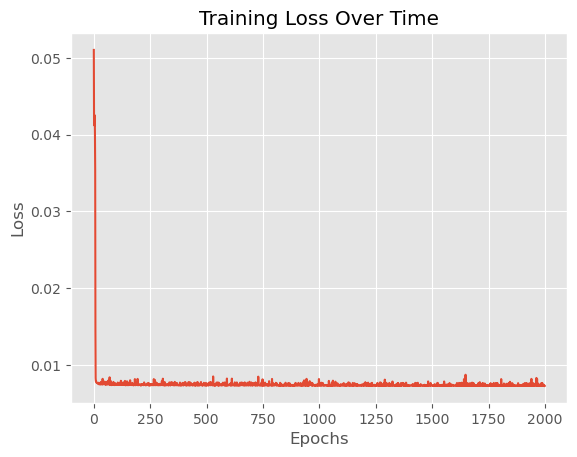

Optimized Architecture: [15, 12, 6, 4] - Validation Loss: 0.0086 - Training Time: 12.28 seconds

Best optimized architecture: [20, 16, 8] with Validation Loss: 0.0014


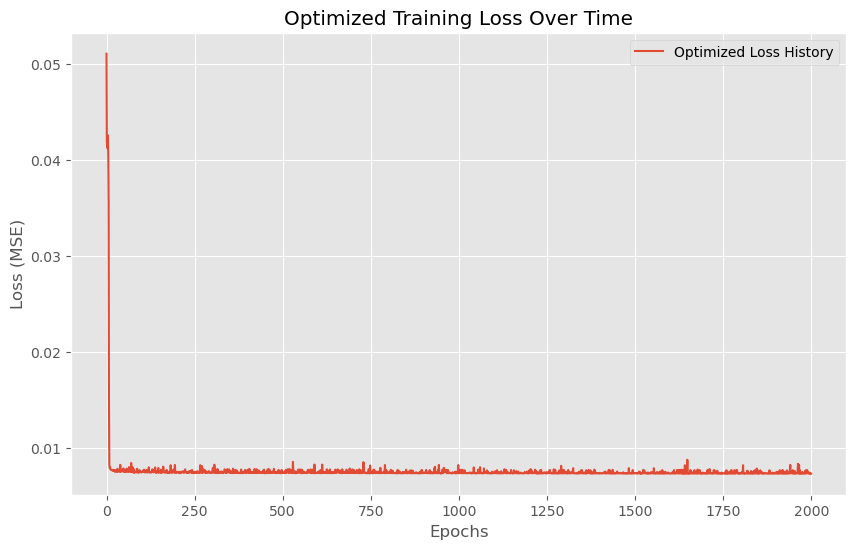

Training R² Score: 0.9663
Validation R² Score: 0.9804


In [724]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def compute_loss(model, X_val, y_val):
    predictions = model.predict(X_val)
    return ((y_val - predictions) ** 2).mean()

# Define the architecture search for optimized techniques.
optimized_architectures = [
    [4],
    [8],
    [16],
    [4, 4],
    [8, 4],
    [16, 8],
    [8, 8],
    [16, 16],
    [20, 16, 8],
    [16, 4],
    [16, 8, 4], 
    [12, 6, 4],
    [15, 12, 6, 4]
]

optimized_results = {}
best_optimized_loss = float('inf')
best_optimized_arch = None

for arch in optimized_architectures:
    print(f"Training optimized network with hidden layers: {arch}")
    # Initialize the network with optimization parameters enabled:
    # momentum=0.9, weight_decay=0.0001, annealing_rate=0.999, and bold driver disabled here.
    model = NeuralNetwork(input_size=6, hidden_sizes=arch, output_size=1, activation="sigmoid",
                          learning_rate=0.5, momentum=0.9, weight_decay=0.0001, annealing_rate=0.999,
                          bold_driver_enabled=False)
    
    start_time = time.time()
    model.train(X_train, y_train, epochs=2000, batch_size=20)
    training_time = time.time() - start_time
    
    val_loss = compute_loss(model, X_val, y_val)
    optimized_results[str(arch)] = (val_loss, training_time)
    print(f"Optimized Architecture: {arch} - Validation Loss: {val_loss:.4f} - Training Time: {training_time:.2f} seconds\n")
    
    if val_loss < best_optimized_loss:
        best_optimized_loss = val_loss
        best_optimized_arch = arch

print(f"Best optimized architecture: {best_optimized_arch} with Validation Loss: {best_optimized_loss:.4f}")

# Optional: Plot loss curves for the best optimized model
plt.figure(figsize=(10, 6))
plt.plot(model.loss_history, label='Optimized Loss History')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Optimized Training Loss Over Time")
plt.legend()
plt.show()

train_score = ANN.score(X_train, y_train)
val_score = ANN.score(X_val, y_val)

print(f"Training R² Score: {train_score:.4f}")
print(f"Validation R² Score: {val_score:.4f}")


Optimized Model - Training R² Score: 0.9600
Optimized Model - Validation R² Score: 0.9667
Epoch 0: Loss = 0.04890937164076962
Epoch 100: Loss = 0.002184824589020668
Epoch 200: Loss = 0.0016644015936881312
Epoch 300: Loss = 0.001472153622090194
Epoch 400: Loss = 0.0014087429043145106
Epoch 500: Loss = 0.001398554934341687
Epoch 600: Loss = 0.0014017459586979
Epoch 700: Loss = 0.0013938867903994963
Epoch 800: Loss = 0.0013883169810007272
Epoch 900: Loss = 0.0014096778946488466
Epoch 1000: Loss = 0.0013631518734653536
Epoch 1100: Loss = 0.001354803633208367
Epoch 1200: Loss = 0.001352390725593366
Epoch 1300: Loss = 0.0013459165517660588
Epoch 1400: Loss = 0.0013218478323506883
Epoch 1500: Loss = 0.001344070971571809
Epoch 1600: Loss = 0.0013319282844278422
Epoch 1700: Loss = 0.0013248803748190418
Epoch 1800: Loss = 0.0013252785641037273
Epoch 1900: Loss = 0.0013276104000241962


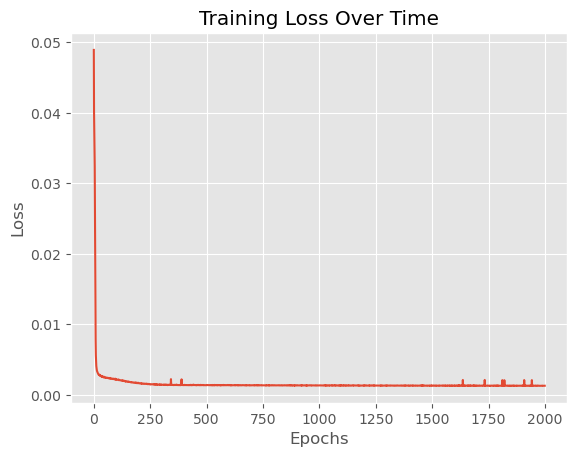

Baseline Model - Training R² Score: 0.9686
Baseline Model - Validation R² Score: 0.9741
Validation Loss for Base Model: 0.0086
Validation Loss for Base Model: 0.0015


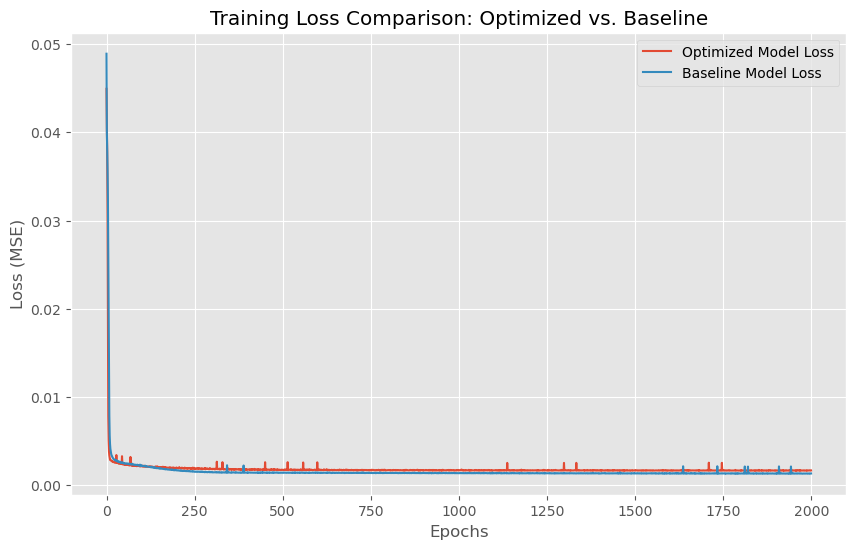

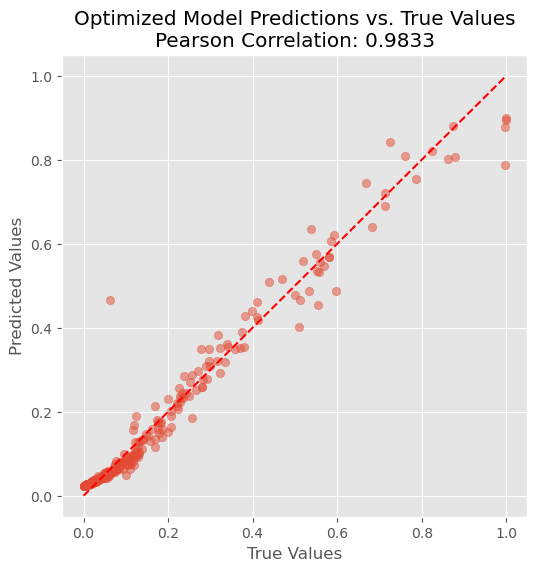

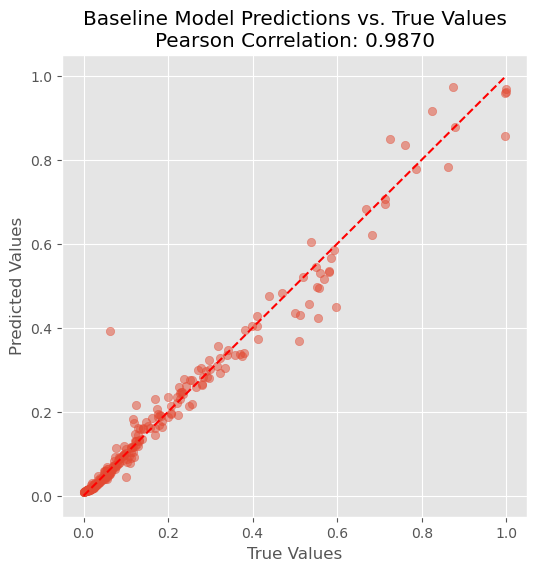

In [733]:
# Evaluate the best optimized model.
optimized_train_score = best_model.score(X_train, y_train)
optimized_val_score = best_model.score(X_val, y_val)
print(f"Optimized Model - Training R² Score: {optimized_train_score:.4f}")
print(f"Optimized Model - Validation R² Score: {optimized_val_score:.4f}")

# Train a baseline model (with no optimizations).
baseline_model = NeuralNetwork(
    input_size=6, 
    hidden_sizes=[8, 6],   # same architecture as best optimized
    output_size=1, 
    activation="sigmoid",
    learning_rate=0.5, 
    momentum=0.0, 
    weight_decay=0.0, 
    annealing_rate=1.0,
    bold_driver_enabled=False
)
baseline_model.train(X_train, y_train, epochs=2000, batch_size=20)
baseline_train_score = baseline_model.score(X_train, y_train)
baseline_val_score = baseline_model.score(X_val, y_val)
print(f"Baseline Model - Training R² Score: {baseline_train_score:.4f}")
print(f"Baseline Model - Validation R² Score: {baseline_val_score:.4f}")
val_loss = compute_loss(model, X_val, y_val)
print(f"Validation Loss for Base Model: {val_loss:.4f}")


val_loss = compute_loss(best_model, X_val, y_val)
print(f"Validation Loss for Base Model: {val_loss:.4f}")


# Plot loss curves for both models.
plt.figure(figsize=(10, 6))
plt.plot(best_model.loss_history, label='Optimized Model Loss')
plt.plot(baseline_model.loss_history, label='Baseline Model Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Comparison: Optimized vs. Baseline")
plt.legend()
plt.show()

# Optionally, plot scatter plots (or correlation plots) of predictions vs. true values.
def plot_predictions(model, X_val, y_val, title):
    predictions = model.predict(X_val).flatten()
    y_true = y_val.flatten()
    corr_coef = np.corrcoef(y_true, predictions)[0, 1]
    
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, predictions, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{title}\nPearson Correlation: {corr_coef:.4f}")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.show()

plot_predictions(best_model, X_val, y_val, "Optimized Model Predictions vs. True Values")
plot_predictions(baseline_model, X_val, y_val, "Baseline Model Predictions vs. True Values")


Training optimized network with hidden layers: [4]
Epoch 0: Loss = 0.056395406222034664
Epoch 100: Loss = 0.0021350576819228915
Epoch 200: Loss = 0.0019730727877952593
Epoch 300: Loss = 0.0019273915802314869
Epoch 400: Loss = 0.001929973349523127
Epoch 500: Loss = 0.001918244034712164
Epoch 600: Loss = 0.0019060538150430556
Epoch 700: Loss = 0.0019185074588185065
Epoch 800: Loss = 0.0019059955563872468
Epoch 900: Loss = 0.0019149866405478693
Epoch 1000: Loss = 0.0019125083226922246
Epoch 1100: Loss = 0.00190627855838641
Epoch 1200: Loss = 0.0019136144445043811
Epoch 1300: Loss = 0.0019037970651594037
Epoch 1400: Loss = 0.00190434326203611
Epoch 1500: Loss = 0.0019050543012681437
Epoch 1600: Loss = 0.0019153040999027938
Epoch 1700: Loss = 0.0019031009842465122
Epoch 1800: Loss = 0.0019182540654148117
Epoch 1900: Loss = 0.001913770324788762


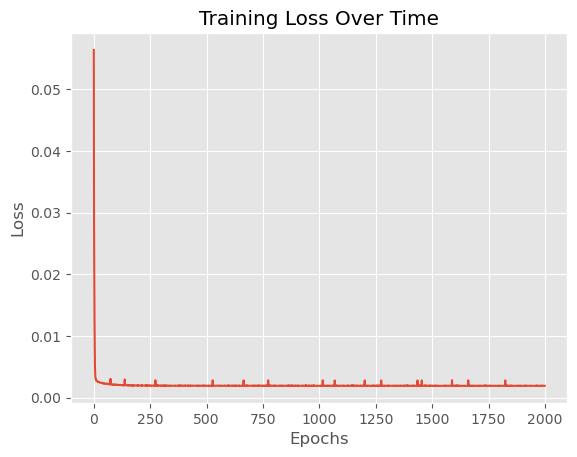

Optimized Architecture: [4] - Validation Loss: 0.0018 - Training Time: 5.85 seconds

Training optimized network with hidden layers: [8]
Epoch 0: Loss = 0.046054235294245
Epoch 100: Loss = 0.002355370430217819
Epoch 200: Loss = 0.0021043591985026215
Epoch 300: Loss = 0.0019229109285338396
Epoch 400: Loss = 0.0018366048978183688
Epoch 500: Loss = 0.0018109649129866429
Epoch 600: Loss = 0.0018038236484019781
Epoch 700: Loss = 0.0018166964023848653
Epoch 800: Loss = 0.0018131779549339978
Epoch 900: Loss = 0.001808936547385959
Epoch 1000: Loss = 0.0018473222789774778
Epoch 1100: Loss = 0.0018409732209722816
Epoch 1200: Loss = 0.001833565362147418
Epoch 1300: Loss = 0.00180898504037206
Epoch 1400: Loss = 0.0018193228890148482
Epoch 1500: Loss = 0.001796853103092768
Epoch 1600: Loss = 0.001814518367056209
Epoch 1700: Loss = 0.0017968088868245526
Epoch 1800: Loss = 0.0018108669381565246
Epoch 1900: Loss = 0.0018028583249086736


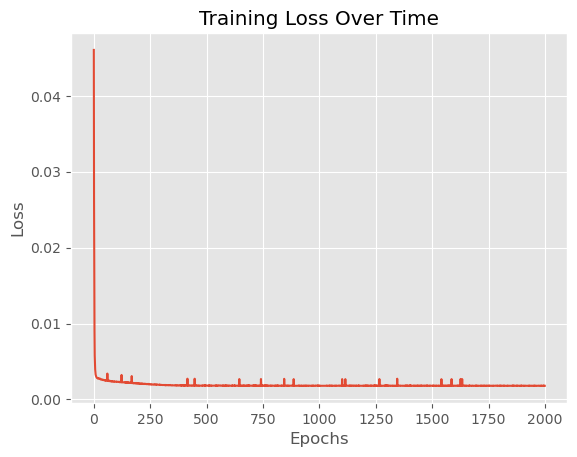

Optimized Architecture: [8] - Validation Loss: 0.0017 - Training Time: 5.71 seconds

Training optimized network with hidden layers: [16]
Epoch 0: Loss = 0.04256013148568674
Epoch 100: Loss = 0.0021046552666378294
Epoch 200: Loss = 0.001937366239906531
Epoch 300: Loss = 0.0018119611797514843
Epoch 400: Loss = 0.001772999548721832
Epoch 500: Loss = 0.001793033435415745
Epoch 600: Loss = 0.001766360449758319
Epoch 700: Loss = 0.0017615922939075129
Epoch 800: Loss = 0.0026239011915031325
Epoch 900: Loss = 0.0017678549647580394
Epoch 1000: Loss = 0.0017813073100047178
Epoch 1100: Loss = 0.0017698016592967744
Epoch 1200: Loss = 0.001756952760107882
Epoch 1300: Loss = 0.0017923456940167302
Epoch 1400: Loss = 0.0017537770902745825
Epoch 1500: Loss = 0.0017478715246478308
Epoch 1600: Loss = 0.001753678375808401
Epoch 1700: Loss = 0.0017436589806017033
Epoch 1800: Loss = 0.0017542423711791432
Epoch 1900: Loss = 0.0017401549215247743


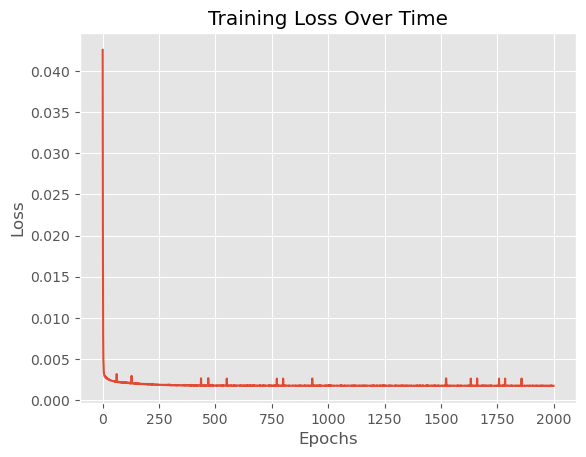

Optimized Architecture: [16] - Validation Loss: 0.0016 - Training Time: 5.46 seconds

Training optimized network with hidden layers: [4, 4]
Epoch 0: Loss = 0.045639723201489006
Epoch 100: Loss = 0.007946943766700005
Epoch 200: Loss = 0.0077810224954610865
Epoch 300: Loss = 0.007736709839088519
Epoch 400: Loss = 0.007698427378406404
Epoch 500: Loss = 0.00765867326688273
Epoch 600: Loss = 0.007586550840238193
Epoch 700: Loss = 0.0032533694529318477
Epoch 800: Loss = 0.002623869312560837
Epoch 900: Loss = 0.00254930087525917
Epoch 1000: Loss = 0.002489335296543173
Epoch 1100: Loss = 0.002478785003295706
Epoch 1200: Loss = 0.0024418283653552253
Epoch 1300: Loss = 0.0024399019270109346
Epoch 1400: Loss = 0.0024177888081348964
Epoch 1500: Loss = 0.0024105444870248815
Epoch 1600: Loss = 0.0024160865305419793
Epoch 1700: Loss = 0.0023855651500957974
Epoch 1800: Loss = 0.0023886690900699796
Epoch 1900: Loss = 0.002383024939053551


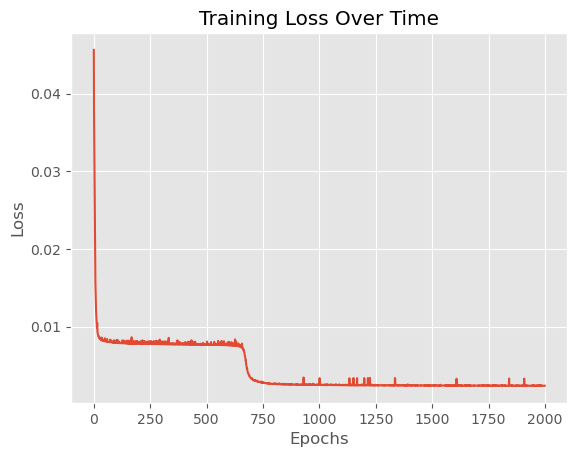

Optimized Architecture: [4, 4] - Validation Loss: 0.0021 - Training Time: 6.82 seconds

Training optimized network with hidden layers: [8, 4]
Epoch 0: Loss = 0.04206982081177424
Epoch 100: Loss = 0.007255149032859138
Epoch 200: Loss = 0.0025959668954325522
Epoch 300: Loss = 0.002286568906899099
Epoch 400: Loss = 0.0021696413934156784
Epoch 500: Loss = 0.0020394555493327385
Epoch 600: Loss = 0.001964155346930201
Epoch 700: Loss = 0.0018906516686613955
Epoch 800: Loss = 0.0018665895103245071
Epoch 900: Loss = 0.0018412087722532642
Epoch 1000: Loss = 0.0018355522329302043
Epoch 1100: Loss = 0.0018194313624871235
Epoch 1200: Loss = 0.001826558264670806
Epoch 1300: Loss = 0.0017945547080356924
Epoch 1400: Loss = 0.0017602928485701101
Epoch 1500: Loss = 0.0017390055883657186
Epoch 1600: Loss = 0.0017487453980338833
Epoch 1700: Loss = 0.001746449920004072
Epoch 1800: Loss = 0.00176035514846575
Epoch 1900: Loss = 0.0017777775012635206


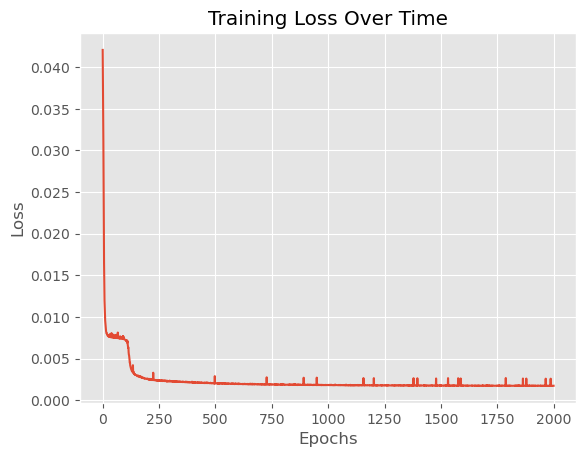

Optimized Architecture: [8, 4] - Validation Loss: 0.0016 - Training Time: 8.17 seconds

Training optimized network with hidden layers: [16, 8]
Epoch 0: Loss = 0.04533376876415013
Epoch 100: Loss = 0.00217156918540267
Epoch 200: Loss = 0.0019597756714914514
Epoch 300: Loss = 0.0018587113000745501
Epoch 400: Loss = 0.00187755939317076
Epoch 500: Loss = 0.001773093704708041
Epoch 600: Loss = 0.0017398349309540346
Epoch 700: Loss = 0.0017694606847615836
Epoch 800: Loss = 0.0017456200823518378
Epoch 900: Loss = 0.001692215514727033
Epoch 1000: Loss = 0.0016895301874374406
Epoch 1100: Loss = 0.0016857606523946115
Epoch 1200: Loss = 0.0016786474248409837
Epoch 1300: Loss = 0.0016719534392705517
Epoch 1400: Loss = 0.0016604513027068148
Epoch 1500: Loss = 0.0016597667064210233
Epoch 1600: Loss = 0.0016576058417296252
Epoch 1700: Loss = 0.001704507343585253
Epoch 1800: Loss = 0.0016652507869650006
Epoch 1900: Loss = 0.0016544183990020256


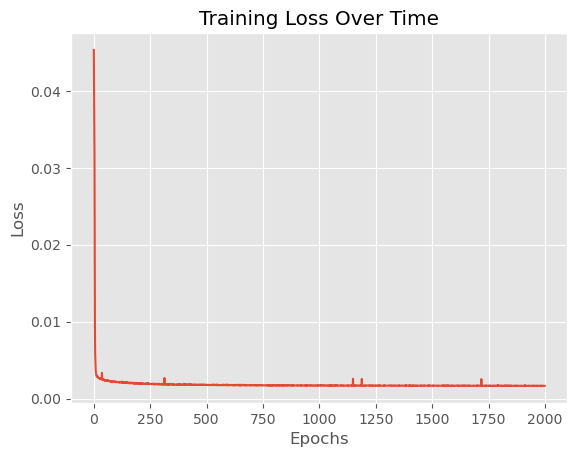

Optimized Architecture: [16, 8] - Validation Loss: 0.0016 - Training Time: 8.56 seconds

Training optimized network with hidden layers: [8, 8]
Epoch 0: Loss = 0.06458662732283735
Epoch 100: Loss = 0.0022823145359639574
Epoch 200: Loss = 0.0020146451573874813
Epoch 300: Loss = 0.0019135277062231543
Epoch 400: Loss = 0.001846663244899274
Epoch 500: Loss = 0.0017831547844039909
Epoch 600: Loss = 0.0017481385667400984
Epoch 700: Loss = 0.001743946076587197
Epoch 800: Loss = 0.0017575685896760805
Epoch 900: Loss = 0.001716875536825277
Epoch 1000: Loss = 0.001710825692170775
Epoch 1100: Loss = 0.0016965217115574426
Epoch 1200: Loss = 0.0017315983438874684
Epoch 1300: Loss = 0.001690183528224268
Epoch 1400: Loss = 0.0017102921318337553
Epoch 1500: Loss = 0.0017003666816428169
Epoch 1600: Loss = 0.001683428639384324
Epoch 1700: Loss = 0.001705166267032852
Epoch 1800: Loss = 0.0016837538136398815
Epoch 1900: Loss = 0.0016908801234110562


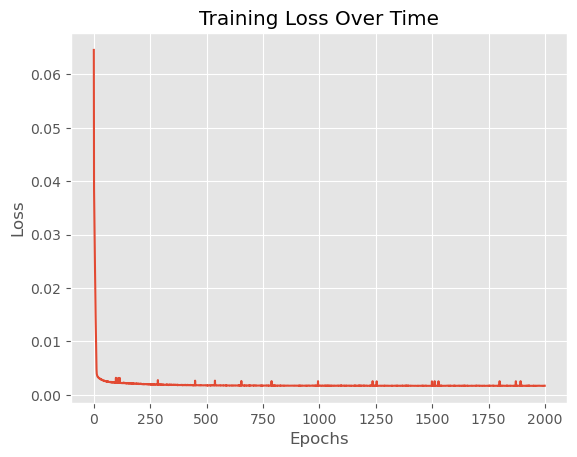

Optimized Architecture: [8, 8] - Validation Loss: 0.0016 - Training Time: 8.08 seconds

Training optimized network with hidden layers: [16, 16]
Epoch 0: Loss = 0.04493151756496161
Epoch 100: Loss = 0.002157932090513685
Epoch 200: Loss = 0.0019420551513550594
Epoch 300: Loss = 0.0018105034728152288
Epoch 400: Loss = 0.0017509163048152403
Epoch 500: Loss = 0.0017384796118017055
Epoch 600: Loss = 0.0017424842656878013
Epoch 700: Loss = 0.0017086591367027797
Epoch 800: Loss = 0.001707244176883738
Epoch 900: Loss = 0.001686939266756309
Epoch 1000: Loss = 0.0017086332248802212
Epoch 1100: Loss = 0.0016733512449276869
Epoch 1200: Loss = 0.0016672776362838266
Epoch 1300: Loss = 0.00168069671649625
Epoch 1400: Loss = 0.0016715199074517821
Epoch 1500: Loss = 0.0016631243275418797
Epoch 1600: Loss = 0.0016554850446911871
Epoch 1700: Loss = 0.001666166207304794
Epoch 1800: Loss = 0.0016545173320614778
Epoch 1900: Loss = 0.0016449271617694284


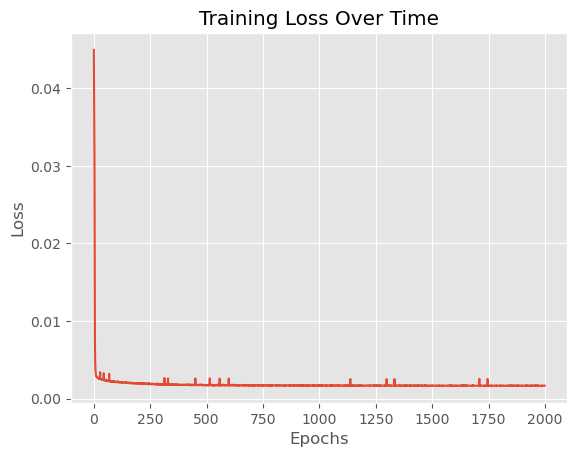

Optimized Architecture: [16, 16] - Validation Loss: 0.0015 - Training Time: 8.59 seconds

Best optimized architecture: [16, 16] with Validation Loss: 0.0015


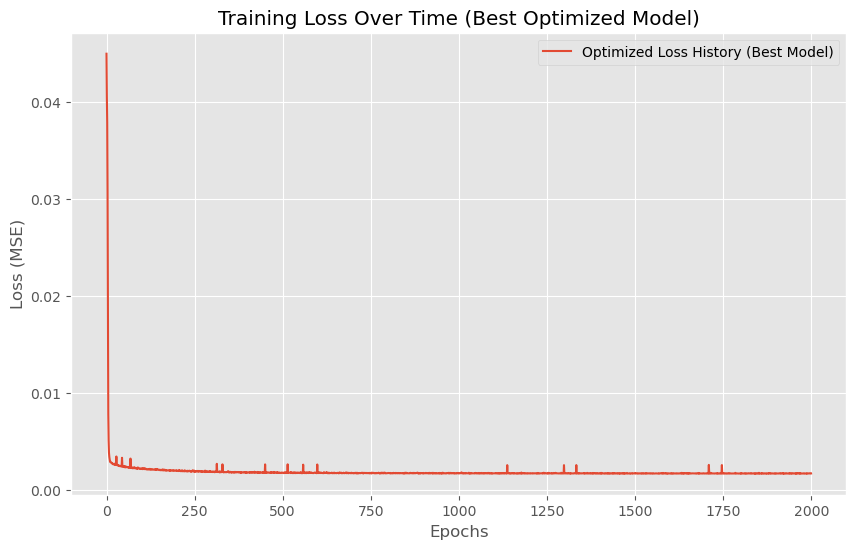

In [711]:
optimized_results = {}
best_optimized_loss = float('inf')
best_optimized_arch = None
best_model = None  # Initialize best_model before the loop

for arch in optimized_architectures:
    print(f"Training optimized network with hidden layers: {arch}")
    model = NeuralNetwork(
        input_size=6, 
        hidden_sizes=arch, 
        output_size=1, 
        activation="sigmoid",
        learning_rate=0.1, 
        momentum=0.9, 
        weight_decay=0.0001, 
        annealing_rate=0.999,
        bold_driver_enabled=False
    )
    
    start_time = time.time()
    model.train(X_train, y_train, epochs=2000, batch_size=20)
    training_time = time.time() - start_time
    
    val_loss = compute_loss(model, X_val, y_val)
    optimized_results[str(arch)] = (val_loss, training_time)
    print(f"Optimized Architecture: {arch} - Validation Loss: {val_loss:.4f} - Training Time: {training_time:.2f} seconds\n")
    
    if val_loss < best_optimized_loss:
        best_optimized_loss = val_loss
        best_optimized_arch = arch
        best_model = model  # Update best_model here

if best_model is None:
    print("No model was selected as best. Check your architecture search and training procedure.")
else:
    print(f"Best optimized architecture: {best_optimized_arch} with Validation Loss: {best_optimized_loss:.4f}")

    # Now you can use best_model, for example, plot its loss history:
    plt.figure(figsize=(10, 6))
    plt.plot(best_model.loss_history, label='Optimized Loss History (Best Model)')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training Loss Over Time (Best Optimized Model)")
    plt.legend()
    plt.show()


Training expanded network with weight decay and extra hidden layers...
Epoch 0: Loss = 0.047855982268469356
Epoch 100: Loss = 0.003215545156332786
Epoch 200: Loss = 0.0032603818369963742
Epoch 300: Loss = 0.003243096402404614
Epoch 400: Loss = 0.0032197151892224647
Epoch 500: Loss = 0.003231350589985901
Epoch 600: Loss = 0.0032242790201686047
Epoch 700: Loss = 0.0032168785176970973
Epoch 800: Loss = 0.0032392180363085043
Epoch 900: Loss = 0.0032258478485059122


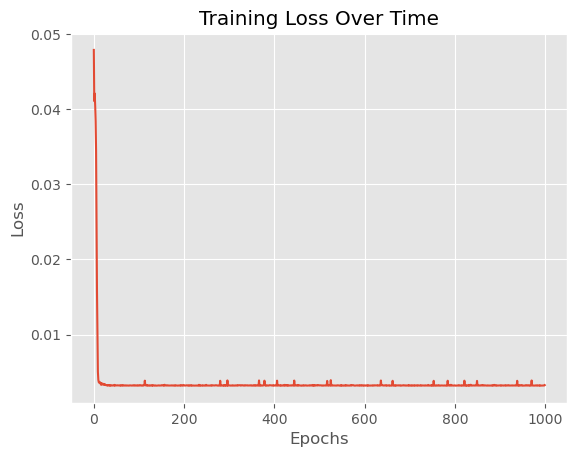

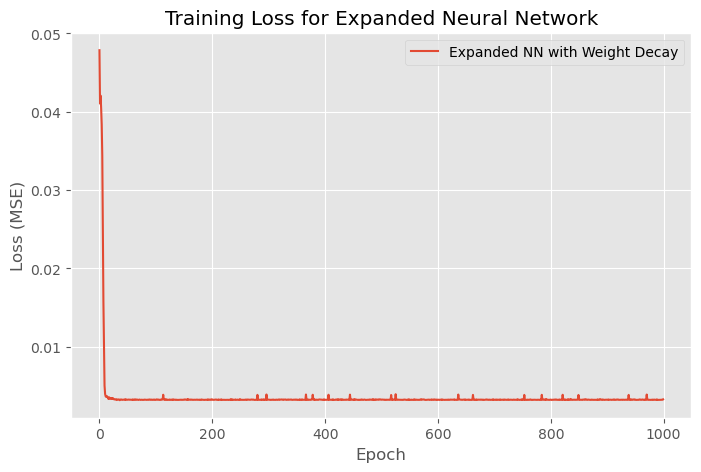

Sample predictions (Expanded NN):
[[0.05823079]
 [0.14969708]
 [0.09518319]
 [0.06406896]
 [0.05553793]]


In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nn_expanded = NeuralNetwork(input_size=6, hidden_sizes=[20, 10, 5], output_size=1, activation="sigmoid", learning_rate=0.5)


# Attach an optimizer with enhanced settings.
nn_expanded.optimizer = Optimizer(
    nn_expanded,
    learning_rate=0.5,
    momentum=0.9,         # Use momentum to smooth updates.
    weight_decay=0.001,     # Apply weight decay (L2 regularization).
    annealing_rate=0.99,    # Slowly decrease the learning rate over epochs.
    bold_driver_enabled=True,
    increase_factor=1.05,
    decrease_factor=0.7
)

# Train the expanded network.
epochs = 1000
batch_size = 32
print("Training expanded network with weight decay and extra hidden layers...")
nn_expanded.train(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Plot and check predictions.
plt.figure(figsize=(8, 5))
plt.plot(nn_expanded.loss_history, label='Expanded NN with Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss for Expanded Neural Network')
plt.legend()
plt.show()

predictions = nn_expanded.predict(X_test)
print("Sample predictions (Expanded NN):")
print(predictions[:5])

Training optimized network with hidden layers: [4]
Epoch 0: Loss = 0.03239137124568969
Epoch 100: Loss = 0.002103741172946492
Epoch 200: Loss = 0.0019963140107769443
Epoch 300: Loss = 0.0019889515690557904
Epoch 400: Loss = 0.0019980981535515567
Epoch 500: Loss = 0.002883840549884257
Epoch 600: Loss = 0.0019816249914988687
Epoch 700: Loss = 0.00199421046987539
Epoch 800: Loss = 0.002012734886847859
Epoch 900: Loss = 0.002017340233518575
Epoch 1000: Loss = 0.0020172094556485435
Epoch 1100: Loss = 0.0019635884585349106
Epoch 1200: Loss = 0.0019697088921616724
Epoch 1300: Loss = 0.0019520855236537017
Epoch 1400: Loss = 0.0019362658075193812
Epoch 1500: Loss = 0.0020055755363104885
Epoch 1600: Loss = 0.00197563292158702
Epoch 1700: Loss = 0.0019649735901033755
Epoch 1800: Loss = 0.0019649511103082165
Epoch 1900: Loss = 0.001953580399188743


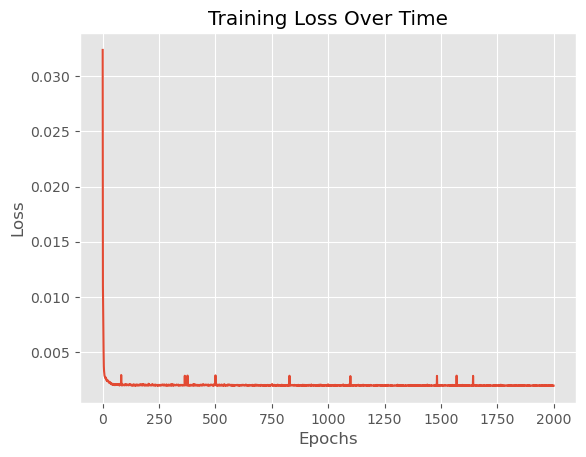

Arch: [4] - Val Loss: 0.0016 - Time: 4.92s

Training optimized network with hidden layers: [8]
Epoch 0: Loss = 0.02902775459120336
Epoch 100: Loss = 0.001902118891197809
Epoch 200: Loss = 0.0018899166573916294
Epoch 300: Loss = 0.0019167028629990647
Epoch 400: Loss = 0.0019193663523443206
Epoch 500: Loss = 0.0019005560700534893
Epoch 600: Loss = 0.001867384747906824
Epoch 700: Loss = 0.0018533203420116298
Epoch 800: Loss = 0.001873519538885483
Epoch 900: Loss = 0.0018794472010205693
Epoch 1000: Loss = 0.0018763028536347044
Epoch 1100: Loss = 0.0018647678903330918
Epoch 1200: Loss = 0.0018765952057606154
Epoch 1300: Loss = 0.0018306269021799565
Epoch 1400: Loss = 0.0018531859694976393
Epoch 1500: Loss = 0.0018543776469667846
Epoch 1600: Loss = 0.001843532655186869
Epoch 1700: Loss = 0.001850161455574017
Epoch 1800: Loss = 0.001855349875632736
Epoch 1900: Loss = 0.0018550582365384595


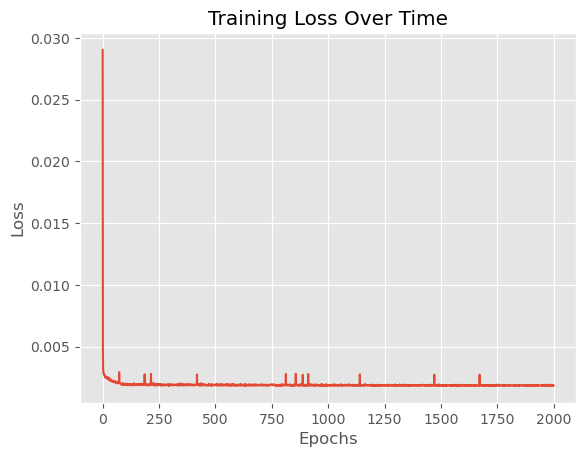

Arch: [8] - Val Loss: 0.0016 - Time: 4.99s

Training optimized network with hidden layers: [16]
Epoch 0: Loss = 0.026914325861201332
Epoch 100: Loss = 0.0018688127639601454
Epoch 200: Loss = 0.0021372030813845712
Epoch 300: Loss = 0.0019036536969084538
Epoch 400: Loss = 0.001939804107078606
Epoch 500: Loss = 0.0019463761986694102
Epoch 600: Loss = 0.0018365751416855643
Epoch 700: Loss = 0.0018507655672730054
Epoch 800: Loss = 0.0018489714249699388
Epoch 900: Loss = 0.0018962064158486063
Epoch 1000: Loss = 0.001854082122205408
Epoch 1100: Loss = 0.0018928247408398892
Epoch 1200: Loss = 0.0018048656170138043
Epoch 1300: Loss = 0.001797914178437304
Epoch 1400: Loss = 0.0018614276083249403
Epoch 1500: Loss = 0.001824591823144256
Epoch 1600: Loss = 0.0017862161483086039
Epoch 1700: Loss = 0.001830509965656252
Epoch 1800: Loss = 0.0018061705125202781
Epoch 1900: Loss = 0.0017952321316407039


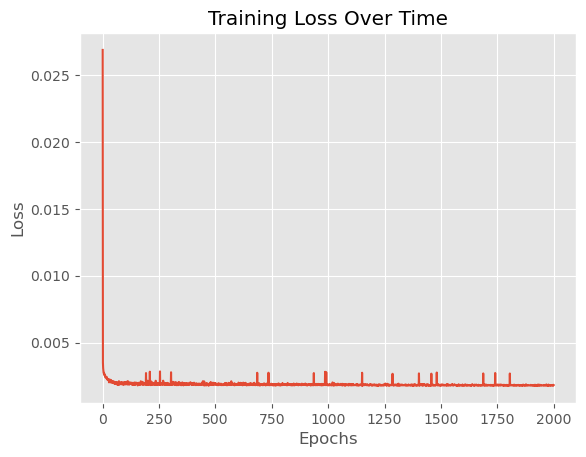

Arch: [16] - Val Loss: 0.0016 - Time: 5.17s

Training optimized network with hidden layers: [4, 4]
Epoch 0: Loss = 0.04667743048161293
Epoch 100: Loss = 0.002326574930151832
Epoch 200: Loss = 0.0022347377409186625
Epoch 300: Loss = 0.002187496031515381
Epoch 400: Loss = 0.002247004297164316
Epoch 500: Loss = 0.002156496908240719
Epoch 600: Loss = 0.0022484817213388455
Epoch 700: Loss = 0.00225416093582023
Epoch 800: Loss = 0.002253708416863294
Epoch 900: Loss = 0.0021893596302088644
Epoch 1000: Loss = 0.00216924898128263
Epoch 1100: Loss = 0.0021826590663611175
Epoch 1200: Loss = 0.0021593690030888815
Epoch 1300: Loss = 0.002170046574179786
Epoch 1400: Loss = 0.0022044881264955533
Epoch 1500: Loss = 0.002130051834911937
Epoch 1600: Loss = 0.0021620342155185285
Epoch 1700: Loss = 0.0021405290896203645
Epoch 1800: Loss = 0.002132877399972898
Epoch 1900: Loss = 0.002146460149350379


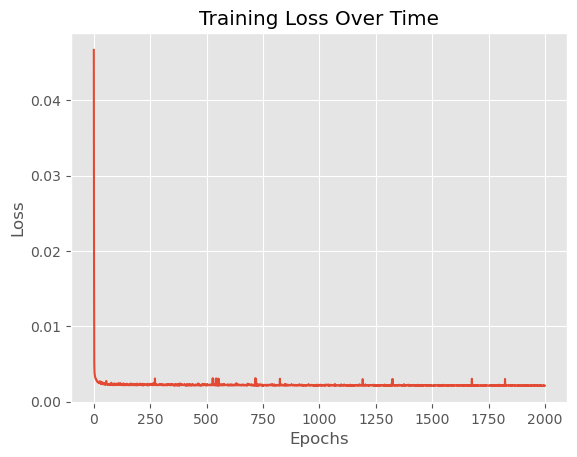

Arch: [4, 4] - Val Loss: 0.0016 - Time: 6.74s

Training optimized network with hidden layers: [8, 4]
Epoch 0: Loss = 0.03867439815736709
Epoch 100: Loss = 0.002059535652519942
Epoch 200: Loss = 0.0017599728289967465
Epoch 300: Loss = 0.001789004509338085
Epoch 400: Loss = 0.0017959661741498965
Epoch 500: Loss = 0.0017191071268158509
Epoch 600: Loss = 0.001710036214513065
Epoch 700: Loss = 0.0017521751168736658
Epoch 800: Loss = 0.001718468763823481
Epoch 900: Loss = 0.001756985054416993
Epoch 1000: Loss = 0.0017276095707721671
Epoch 1100: Loss = 0.0017121146727878463
Epoch 1200: Loss = 0.0016964213385494426
Epoch 1300: Loss = 0.001686275064665952
Epoch 1400: Loss = 0.0017323825355836419
Epoch 1500: Loss = 0.001748409008096888
Epoch 1600: Loss = 0.0017118499546454112
Epoch 1700: Loss = 0.0017136443821364636
Epoch 1800: Loss = 0.0017112411575125437
Epoch 1900: Loss = 0.0016905396783355867


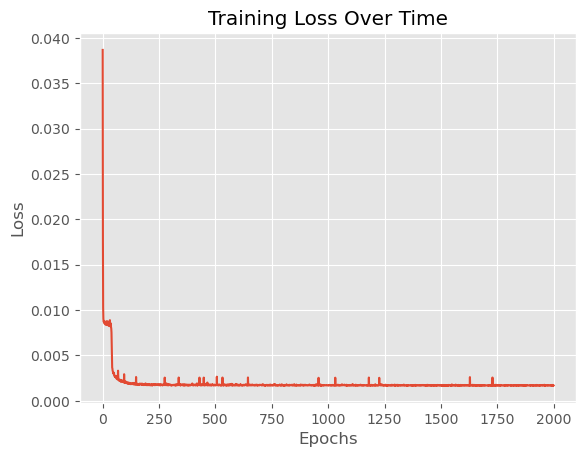

Arch: [8, 4] - Val Loss: 0.0016 - Time: 6.83s

Training optimized network with hidden layers: [16, 8]
Epoch 0: Loss = 0.04246617628309217
Epoch 100: Loss = 0.0016828392091470966
Epoch 200: Loss = 0.0016867923880515283
Epoch 300: Loss = 0.0016401539850571588
Epoch 400: Loss = 0.0016585491207411491
Epoch 500: Loss = 0.0016181439982476536
Epoch 600: Loss = 0.0016065873399855061
Epoch 700: Loss = 0.0015887682582543241
Epoch 800: Loss = 0.0016964888857112195
Epoch 900: Loss = 0.0016371209751851567
Epoch 1000: Loss = 0.0016034336255940944
Epoch 1100: Loss = 0.0016225217633444799
Epoch 1200: Loss = 0.0016028990243457661
Epoch 1300: Loss = 0.001601370982851925
Epoch 1400: Loss = 0.0016090518792418814
Epoch 1500: Loss = 0.0016160374690814517
Epoch 1600: Loss = 0.0015951797421444474
Epoch 1700: Loss = 0.0015990943102711641
Epoch 1800: Loss = 0.0016076517261223496
Epoch 1900: Loss = 0.0016347587949293604


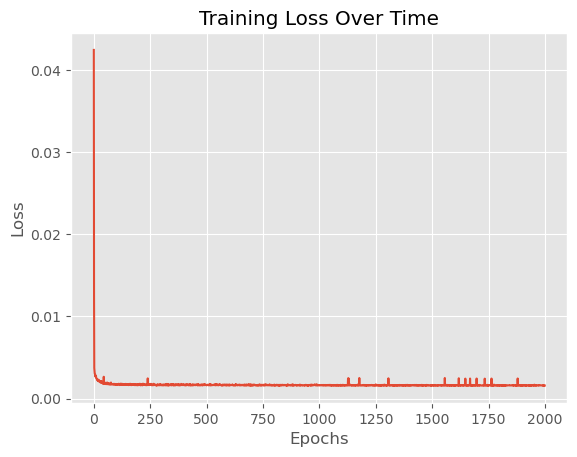

Arch: [16, 8] - Val Loss: 0.0014 - Time: 7.29s

Training optimized network with hidden layers: [8, 8]
Epoch 0: Loss = 0.04319691026151045
Epoch 100: Loss = 0.0018249693327085784
Epoch 200: Loss = 0.0017635141235898062
Epoch 300: Loss = 0.0017796159959828086
Epoch 400: Loss = 0.001821306479453889
Epoch 500: Loss = 0.0017428149424837981
Epoch 600: Loss = 0.0017280335795144368
Epoch 700: Loss = 0.0017523862106096145
Epoch 800: Loss = 0.0017641398066697562
Epoch 900: Loss = 0.0017665959201887361
Epoch 1000: Loss = 0.0017749264671529218
Epoch 1100: Loss = 0.001762007707087915
Epoch 1200: Loss = 0.0017808891793577146
Epoch 1300: Loss = 0.0017083756084567494
Epoch 1400: Loss = 0.0017656562957613791
Epoch 1500: Loss = 0.0017182397272875191
Epoch 1600: Loss = 0.0017509402911718246
Epoch 1700: Loss = 0.0017402216917035472
Epoch 1800: Loss = 0.0017478653801603645
Epoch 1900: Loss = 0.0017299940788687595


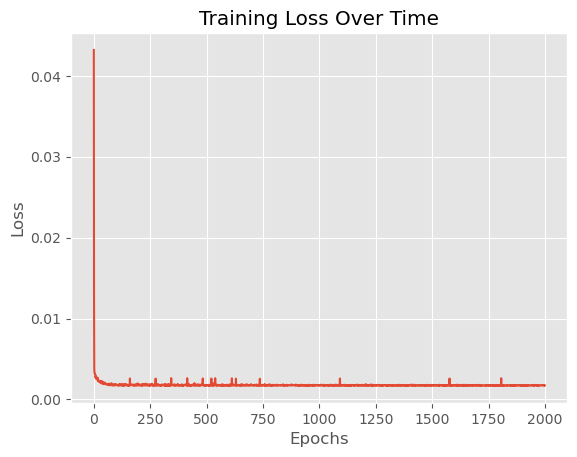

Arch: [8, 8] - Val Loss: 0.0015 - Time: 7.71s

Training optimized network with hidden layers: [16, 16]
Epoch 0: Loss = 0.054596704432284586
Epoch 100: Loss = 0.0017144528775774519
Epoch 200: Loss = 0.0017015531169776003
Epoch 300: Loss = 0.0016677965174863455
Epoch 400: Loss = 0.0017245971467916355
Epoch 500: Loss = 0.0016691449642058658
Epoch 600: Loss = 0.0017549958204753123
Epoch 700: Loss = 0.0016771936003420718
Epoch 800: Loss = 0.001713638872111703
Epoch 900: Loss = 0.0016740004915470766
Epoch 1000: Loss = 0.001683478964509219
Epoch 1100: Loss = 0.0016502680634472371
Epoch 1200: Loss = 0.0016432444749674936
Epoch 1300: Loss = 0.0016674414474853625
Epoch 1400: Loss = 0.0016599687271708476
Epoch 1500: Loss = 0.0016271579561038922
Epoch 1600: Loss = 0.0016889481591000697
Epoch 1700: Loss = 0.0016733274926399708
Epoch 1800: Loss = 0.0016796678703841963
Epoch 1900: Loss = 0.0016260416632366335


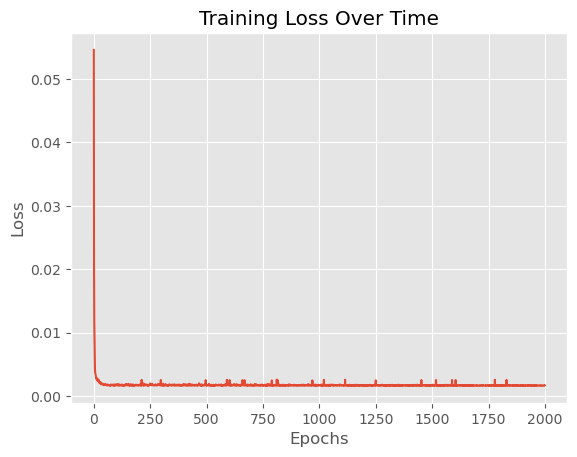

Arch: [16, 16] - Val Loss: 0.0015 - Time: 7.53s

Training optimized network with hidden layers: [20, 16, 8]
Epoch 0: Loss = 0.049492655026284686
Epoch 100: Loss = 0.00241747414588838
Epoch 200: Loss = 0.0019036136816119767
Epoch 300: Loss = 0.001746737694977602
Epoch 400: Loss = 0.001828836922675117
Epoch 500: Loss = 0.0017289903990044184
Epoch 600: Loss = 0.0016924620019651108
Epoch 700: Loss = 0.0016667775066200002
Epoch 800: Loss = 0.0016830908787788751
Epoch 900: Loss = 0.001714322689362357
Epoch 1000: Loss = 0.0016951647892610529
Epoch 1100: Loss = 0.0016405063382917702
Epoch 1200: Loss = 0.0016391599444856638
Epoch 1300: Loss = 0.0017364144176159689
Epoch 1400: Loss = 0.0016526168349499121
Epoch 1500: Loss = 0.0016291772081775794
Epoch 1600: Loss = 0.001647470273587952
Epoch 1700: Loss = 0.0015810616514859964
Epoch 1800: Loss = 0.0015939988099472893
Epoch 1900: Loss = 0.0015804633714045135


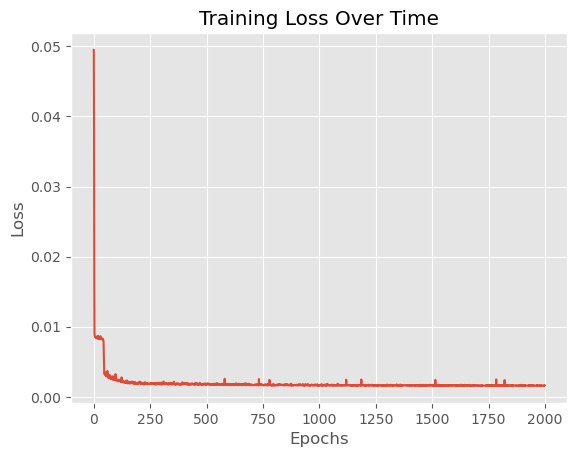

Arch: [20, 16, 8] - Val Loss: 0.0014 - Time: 10.17s

Training optimized network with hidden layers: [16, 4]
Epoch 0: Loss = 0.04088867319195097
Epoch 100: Loss = 0.001729336126265474
Epoch 200: Loss = 0.001637581993943782
Epoch 300: Loss = 0.0016436730177177624
Epoch 400: Loss = 0.001576155879412046
Epoch 500: Loss = 0.0016190396732551774
Epoch 600: Loss = 0.0015695837518841993
Epoch 700: Loss = 0.0016291628060477062
Epoch 800: Loss = 0.0016500516546326155
Epoch 900: Loss = 0.0015892291211017189
Epoch 1000: Loss = 0.0016016448046187756
Epoch 1100: Loss = 0.0015816053869058785
Epoch 1200: Loss = 0.001572982185697712
Epoch 1300: Loss = 0.0015802037766048263
Epoch 1400: Loss = 0.0015808126103569959
Epoch 1500: Loss = 0.0016046398632067417
Epoch 1600: Loss = 0.0015578465379695794
Epoch 1700: Loss = 0.0016260862034078306
Epoch 1800: Loss = 0.0015771430713449298
Epoch 1900: Loss = 0.0015608306910392827


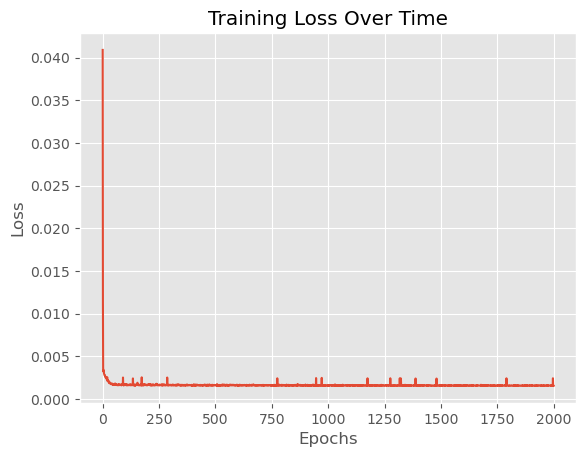

Arch: [16, 4] - Val Loss: 0.0014 - Time: 7.36s

Training optimized network with hidden layers: [16, 8, 4]
Epoch 0: Loss = 0.056171961843368326
Epoch 100: Loss = 0.008270492393460338
Epoch 200: Loss = 0.008088574410232316
Epoch 300: Loss = 0.00807234162610993
Epoch 400: Loss = 0.008465042553810592
Epoch 500: Loss = 0.008105060119953702
Epoch 600: Loss = 0.008047323149772164
Epoch 700: Loss = 0.008275147131815593
Epoch 800: Loss = 0.00806541742302795
Epoch 900: Loss = 0.008040680495246871
Epoch 1000: Loss = 0.008069867884240332
Epoch 1100: Loss = 0.008048040810993515
Epoch 1200: Loss = 0.00805563145816446
Epoch 1300: Loss = 0.008075247879273877
Epoch 1400: Loss = 0.00825004487922443
Epoch 1500: Loss = 0.008046579133952823
Epoch 1600: Loss = 0.008037057526567434
Epoch 1700: Loss = 0.0080449362644804
Epoch 1800: Loss = 0.008041852807336805
Epoch 1900: Loss = 0.008040330794001736


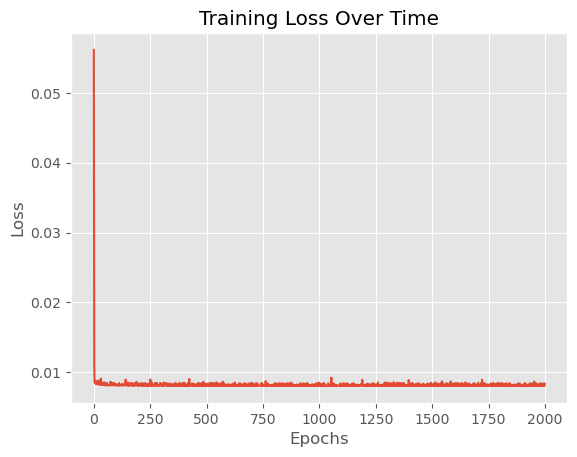

Arch: [16, 8, 4] - Val Loss: 0.0047 - Time: 9.50s

Training optimized network with hidden layers: [12, 6, 4]
Epoch 0: Loss = 0.052383261357202254
Epoch 100: Loss = 0.00849118603999288
Epoch 200: Loss = 0.0082073519117514
Epoch 300: Loss = 0.008180431847425049
Epoch 400: Loss = 0.008352073786420965
Epoch 500: Loss = 0.008170183538745648
Epoch 600: Loss = 0.00819037869447333
Epoch 700: Loss = 0.00816178538115307
Epoch 800: Loss = 0.008162432510489157
Epoch 900: Loss = 0.008197496679182906
Epoch 1000: Loss = 0.008484271642302504
Epoch 1100: Loss = 0.008511671681883515
Epoch 1200: Loss = 0.008168955002665155
Epoch 1300: Loss = 0.008294524227621064
Epoch 1400: Loss = 0.008169155005241915
Epoch 1500: Loss = 0.008171998031996355
Epoch 1600: Loss = 0.008240335784459527
Epoch 1700: Loss = 0.008139278374276682
Epoch 1800: Loss = 0.008175280978147511
Epoch 1900: Loss = 0.008156844879008956


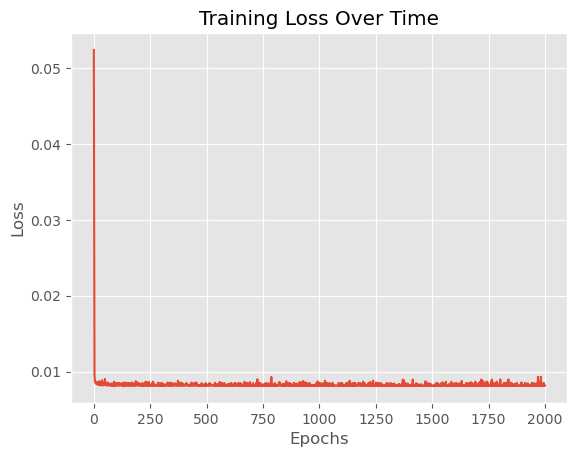

Arch: [12, 6, 4] - Val Loss: 0.0048 - Time: 9.03s

Training optimized network with hidden layers: [15, 12, 6, 4]
Epoch 0: Loss = 0.05302201683916214
Epoch 100: Loss = 0.008352015759682582
Epoch 200: Loss = 0.008447100733972987
Epoch 300: Loss = 0.008313802146164303
Epoch 400: Loss = 0.008383539323532058
Epoch 500: Loss = 0.008318878198787225
Epoch 600: Loss = 0.008293608690462128
Epoch 700: Loss = 0.00827098881917391
Epoch 800: Loss = 0.008233353144090577
Epoch 900: Loss = 0.008249602776202201
Epoch 1000: Loss = 0.008267434083288642
Epoch 1100: Loss = 0.009085220680343918
Epoch 1200: Loss = 0.008211214250419138
Epoch 1300: Loss = 0.008271391747697565
Epoch 1400: Loss = 0.008228807293609893
Epoch 1500: Loss = 0.008244528423393587
Epoch 1600: Loss = 0.008250424347562495
Epoch 1700: Loss = 0.008201056129215394
Epoch 1800: Loss = 0.008223458346607477
Epoch 1900: Loss = 0.00820114918688091


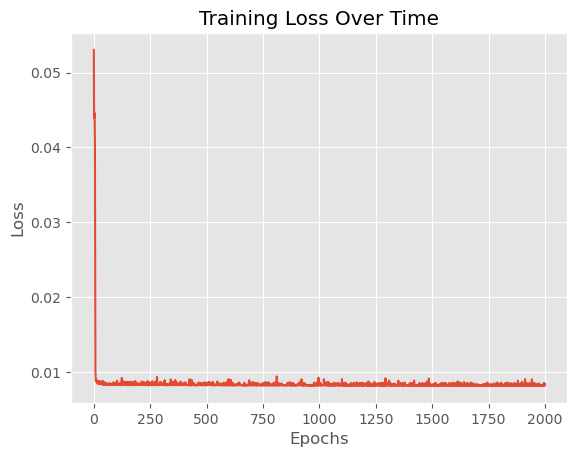

Arch: [15, 12, 6, 4] - Val Loss: 0.0048 - Time: 12.75s

Best optimized arch: [20, 16, 8] with Val Loss: 0.0014


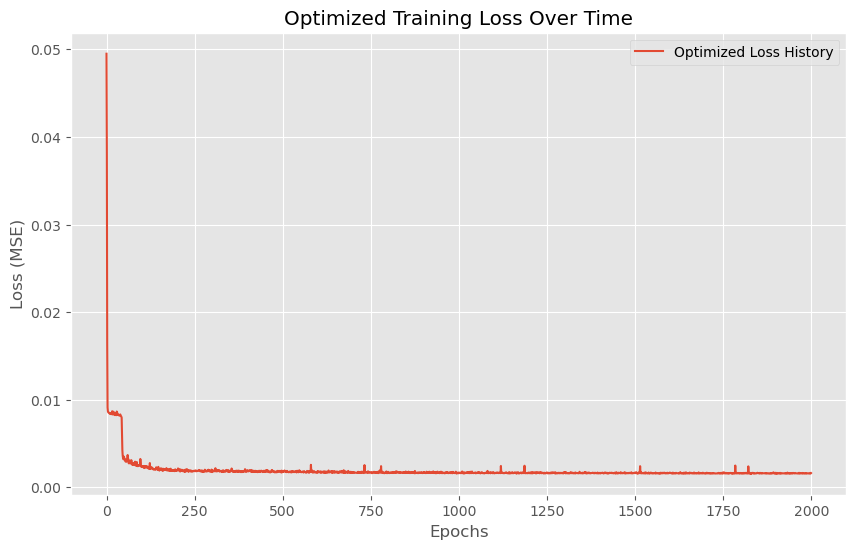

Optimized Model - Training R²: 0.9645
Optimized Model - Validation R²: 0.9607
Epoch 0: Loss = 0.05421624600290482
Epoch 100: Loss = 0.002537322745950261
Epoch 200: Loss = 0.0018157055276870728
Epoch 300: Loss = 0.0014545575202303937
Epoch 400: Loss = 0.0014418931671440016
Epoch 500: Loss = 0.001449509914064086
Epoch 600: Loss = 0.001393972390805598
Epoch 700: Loss = 0.001385294976919535
Epoch 800: Loss = 0.0013628755044526807
Epoch 900: Loss = 0.001352503369517997
Epoch 1000: Loss = 0.001353204168541487
Epoch 1100: Loss = 0.0013438327300643554
Epoch 1200: Loss = 0.0013312462293760716
Epoch 1300: Loss = 0.0013353452492276597
Epoch 1400: Loss = 0.0013206189672069076
Epoch 1500: Loss = 0.0013228561404499634
Epoch 1600: Loss = 0.0013249138129977384
Epoch 1700: Loss = 0.0013115367719972397
Epoch 1800: Loss = 0.001319837584958988
Epoch 1900: Loss = 0.001315822066570993


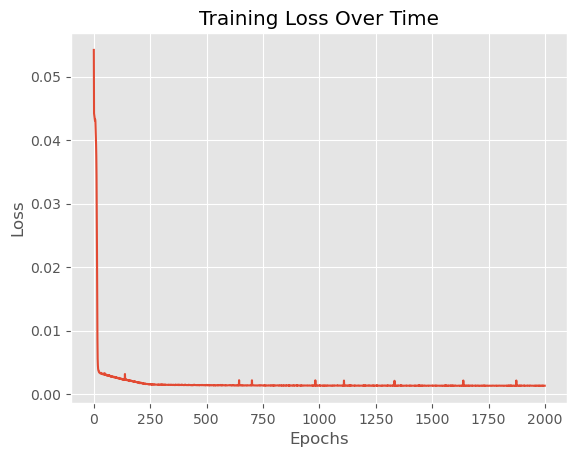

Baseline Model - Training R²: 0.9703
Baseline Model - Validation R²: 0.9674
Baseline Model - Val Loss: 0.0011
Optimized Model - Val Loss: 0.0014


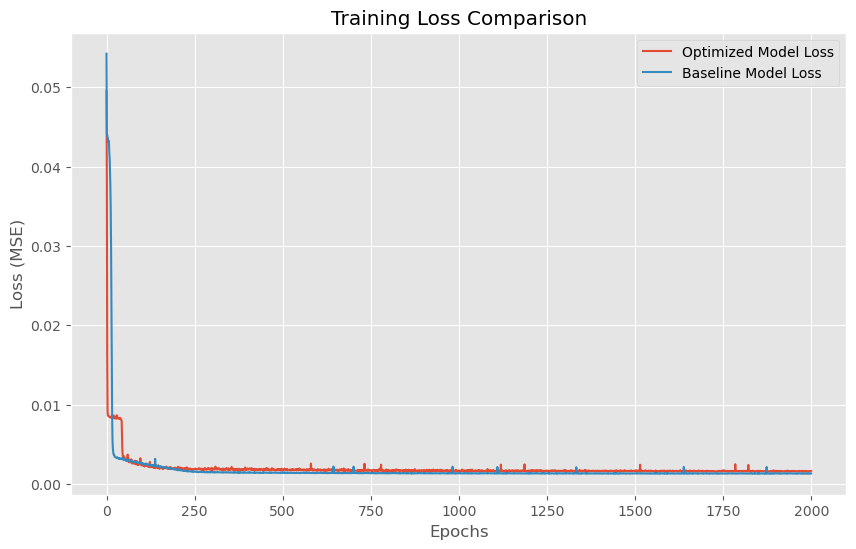

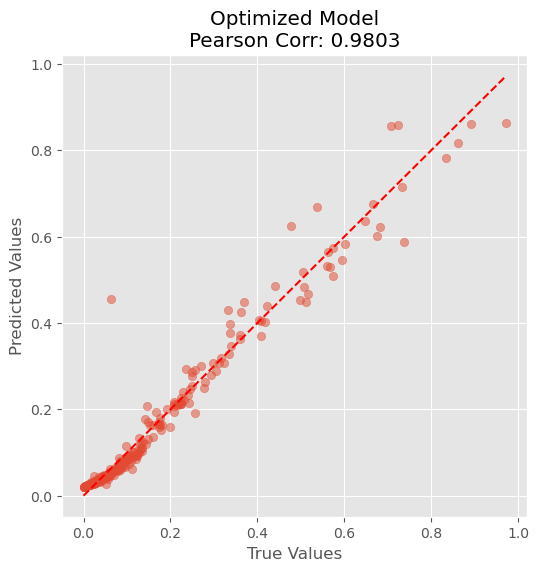

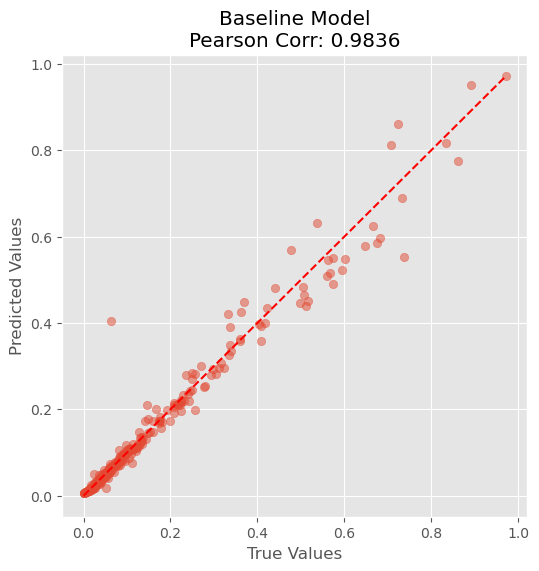

In [781]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
optimized_architectures = [
    [4], [8], [16], [4, 4], [8, 4], [16, 8],
    [8, 8], [16, 16], [20, 16, 8], [16, 4],
    [16, 8, 4], [12, 6, 4], [15, 12, 6, 4]
]

optimized_results = {}
best_optimized_loss = float('inf')
best_optimized_arch = None
best_model = None

# Loop over architectures, train each model, and record its validation loss and training time
for arch in optimized_architectures:
    print(f"Training optimized network with hidden layers: {arch}")
    model = NeuralNetwork(input_size=6, hidden_sizes=arch, output_size=1, activation="sigmoid",
                          learning_rate=0.5, momentum=0.9, weight_decay=0.0001, annealing_rate=0.999,
                          bold_driver_enabled=False)
    start_time = time.time()
    model.train(X_train, y_train, epochs=2000, batch_size=20)
    training_time = time.time() - start_time
    
    # Compute validation loss inline
    val_loss = ((y_test - model.predict(X_test)) ** 2).mean()
    optimized_results[str(arch)] = (val_loss, training_time)
    print(f"Arch: {arch} - Val Loss: {val_loss:.4f} - Time: {training_time:.2f}s\n")
    
    if val_loss < best_optimized_loss:
        best_optimized_loss = val_loss
        best_optimized_arch = arch
        best_model = model

print(f"Best optimized arch: {best_optimized_arch} with Val Loss: {best_optimized_loss:.4f}")

# Plot loss history for the best optimized model
plt.figure(figsize=(10, 6))
plt.plot(best_model.loss_history, label='Optimized Loss History')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Optimized Training Loss Over Time")
plt.legend()
plt.show()

# Evaluate best optimized model using R²
optimized_train_score = best_model.score(X_train, y_train)
optimized_val_score = best_model.score(X_test, y_test)
print(f"Optimized Model - Training R²: {optimized_train_score:.4f}")
print(f"Optimized Model - Validation R²: {optimized_val_score:.4f}")

# Train a baseline model (no optimizations)
baseline_model = NeuralNetwork(
    input_size=6, 
    hidden_sizes=best_optimized_arch,   # predefined architecture
    output_size=1, 
    activation="sigmoid",
    learning_rate=0.5, 
    momentum=0.0, 
    weight_decay=0.0, 
    annealing_rate=1.0,
    bold_driver_enabled=False
)
baseline_model.train(X_train, y_train, epochs=2000, batch_size=20)
baseline_train_score = baseline_model.score(X_train, y_train)
baseline_val_score = baseline_model.score(X_test, y_test)
print(f"Baseline Model - Training R²: {baseline_train_score:.4f}")
print(f"Baseline Model - Validation R²: {baseline_val_score:.4f}")

# Compute and print validation losses
baseline_val_loss = ((y_test - baseline_model.predict(X_test)) ** 2).mean()
best_model_val_loss = ((y_test - best_model.predict(X_test)) ** 2).mean()
print(f"Baseline Model - Val Loss: {baseline_val_loss:.4f}")
print(f"Optimized Model - Val Loss: {best_model_val_loss:.4f}")

# Plot loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(best_model.loss_history, label='Optimized Model Loss')
plt.plot(baseline_model.loss_history, label='Baseline Model Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

# Scatter plot: Optimized model predictions vs. true values
preds_opt = best_model.predict(X_test).flatten()
y_true = y_test.flatten()
corr_coef_opt = np.corrcoef(y_true, preds_opt)[0, 1]
plt.figure(figsize=(6, 6))
plt.scatter(y_true, preds_opt, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Optimized Model\nPearson Corr: {corr_coef_opt:.4f}")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.show()

# Scatter plot: Baseline model predictions vs. true values
preds_base = baseline_model.predict(X_test).flatten()
corr_coef_base = np.corrcoef(y_true, preds_base)[0, 1]
plt.figure(figsize=(6, 6))
plt.scatter(y_true, preds_base, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Baseline Model\nPearson Corr: {corr_coef_base:.4f}")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.show()


In [785]:
new_day_features_original = np.array([[10.5, 3.2, 8.7, 4.1, 10, 5.3]])
new_day_features_scaled = X_scaler.transform(new_day_features_original)

# Identify the target column for Skelton in the original dataframe.
# In your case, the target is ('Mean Daily Flow - Cumecs', 'Skelton')
# Predict in the scaled domain
pred_scaled = best_model.predict(new_day_features_scaled)

pred_original = y_scaler.inverse_transform(pred_scaled)
print("Predicted Mean Daily Flow at Skelton (original scale):", pred_original)

Predicted Mean Daily Flow at Skelton (original scale): [[20.14730129]]
